In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation, thresholding, testingPipeline

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math
import sklearn
from collections import defaultdict
from pprint import pprint
import json
import multiprocessing as mp

mp.set_start_method('spawn')

In [2]:
# data init

# dataset
baseDatasetPath = "../data/datasets"
inclusionThreshold = 0.5
includedSims = 24

# iters to run
iters = [1,2,3,4,5,6,7,8,9,10]

snrs=range(1,7)

#SDs to test
sdMuls = list(range(1, 6))

# gans
batchSize = 64
baseModelPath = "../data/models"
epochs = 5
noiseDim = 200

#results
resultsPath = "../data/results"

<AxesSubplot:>

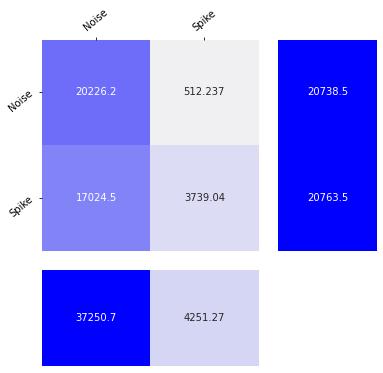

In [34]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = avgs[3][1] 

classes = ["Noise", "Spike"]
fig = plt.figure(figsize=(6,6))

ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (2,0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid((3,3), (0,2), colspan=1, rowspan=2)
sn.color_palette("Paired")
pv = pd.DataFrame(array, index=classes, columns=classes)

c = sn.color_palette("light:b", as_cmap=True)

sn.heatmap(pv, ax=ax1,cmap=c, annot=True, linecolor='b', cbar = False,fmt='g',center=np.mean(pv)[0])
ax1.xaxis.tick_top()
ax1.set_xticklabels(classes,rotation=40)
ax1.set_yticklabels(classes,rotation=40)

sn.heatmap((pd.DataFrame(np.sum(pv,axis=0))).transpose(), ax=ax2,cmap=c,  annot=True, cbar=False, xticklabels=False, yticklabels=False,fmt='g',center=np.mean(pv,axis=0)[0])
sn.heatmap(pd.DataFrame(np.sum(pv,axis=1)), ax=ax3,  annot=True,cmap=c, cbar=False, xticklabels=False, yticklabels=False,fmt='g',center=np.mean(pv,axis=1)[0])


Generating dataset for iteration 6
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


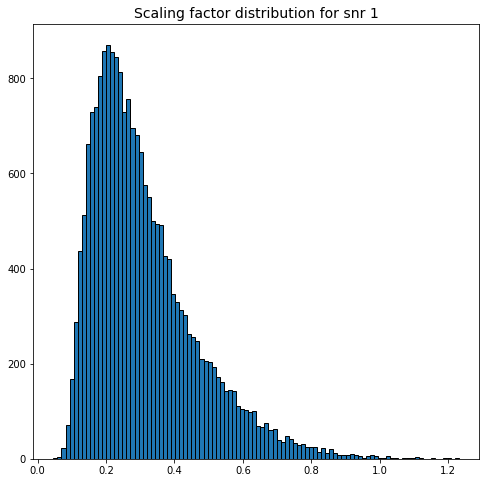

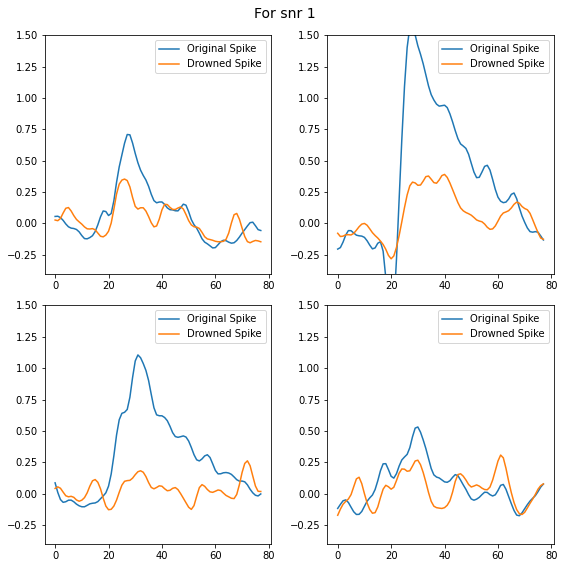

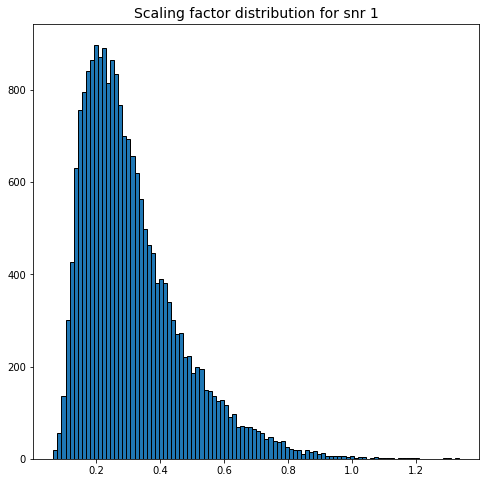

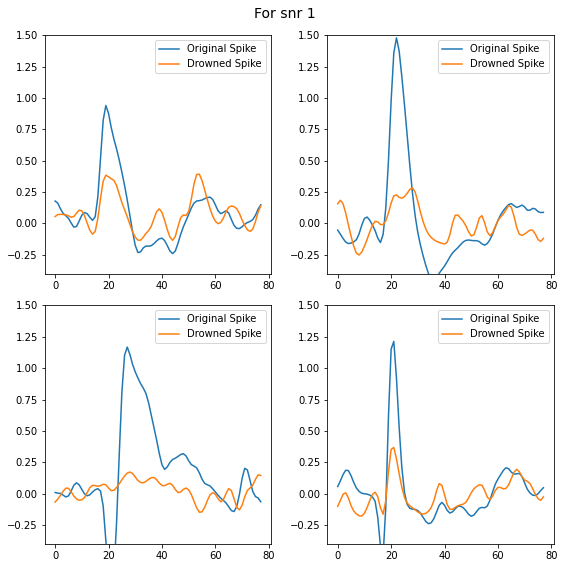

Generating dataset with snr 2


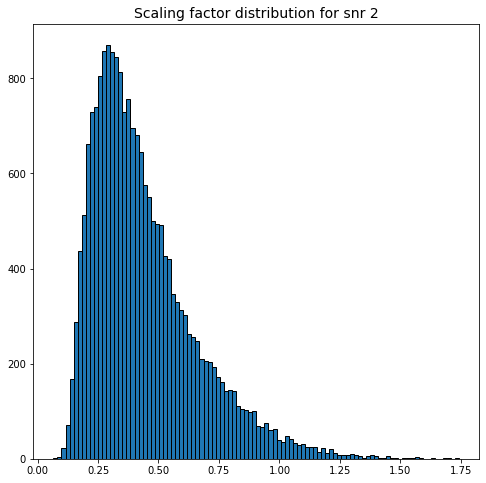

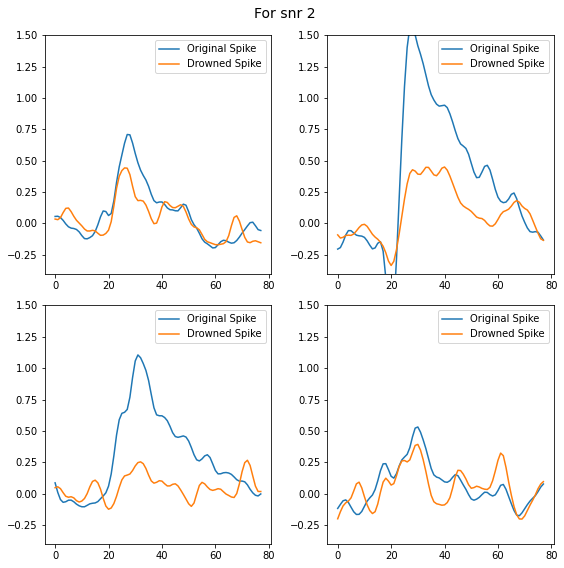

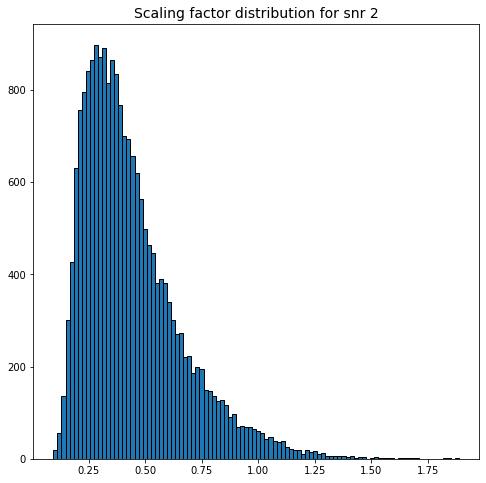

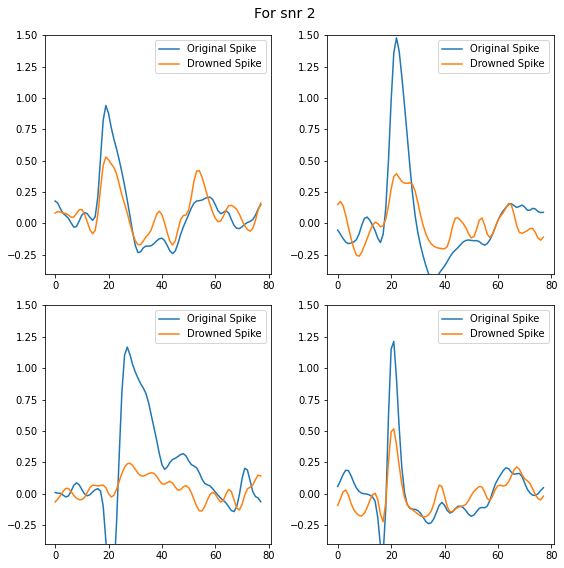

Generating dataset with snr 3


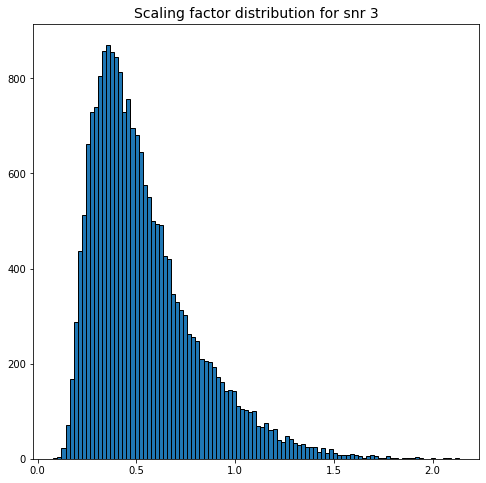

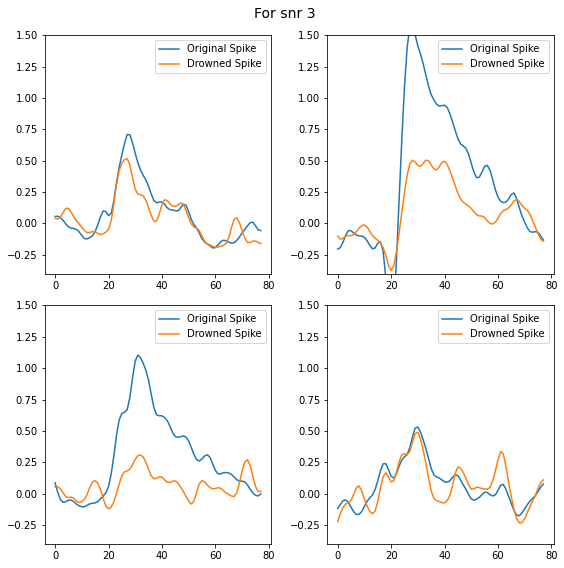

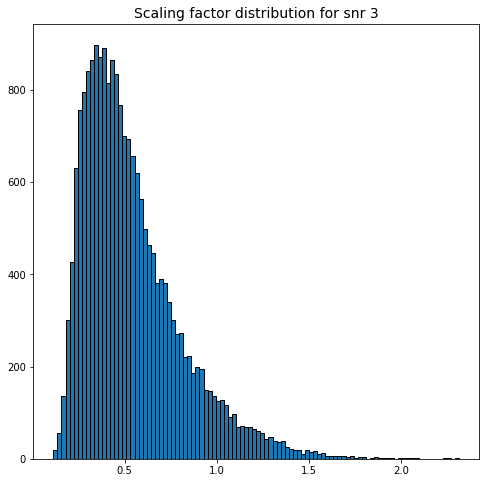

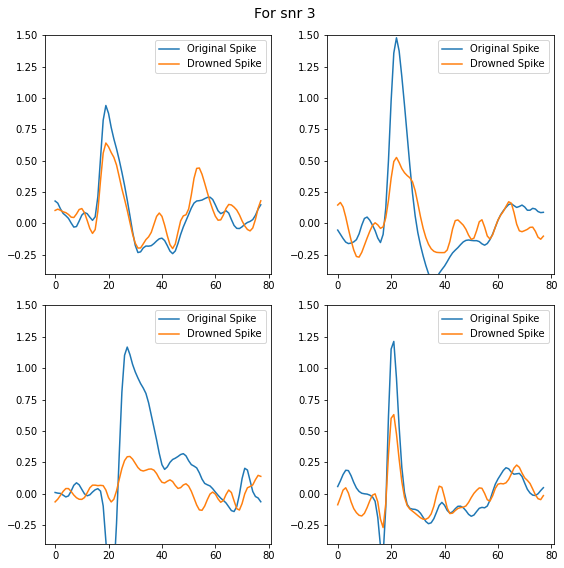

Generating dataset with snr 4


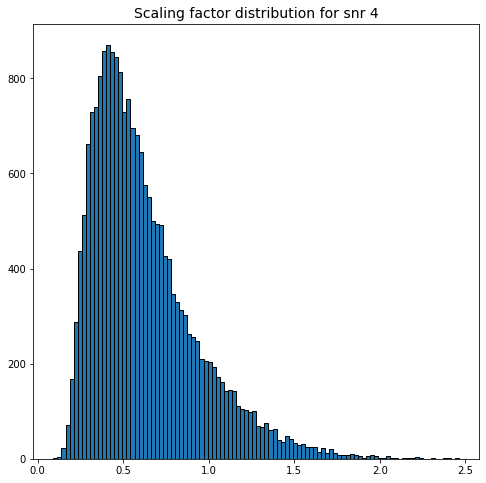

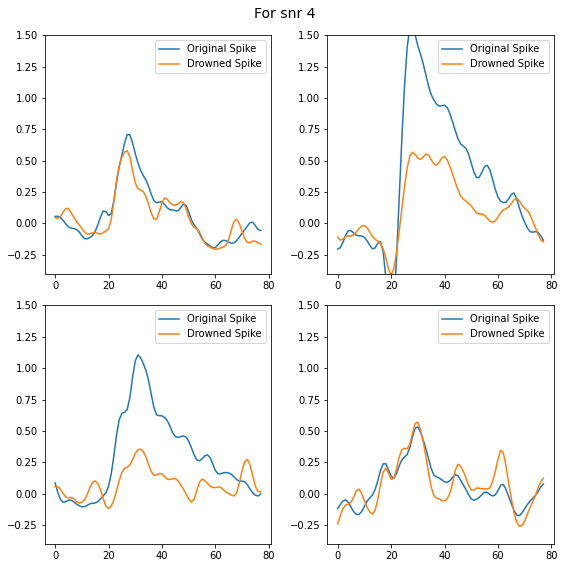

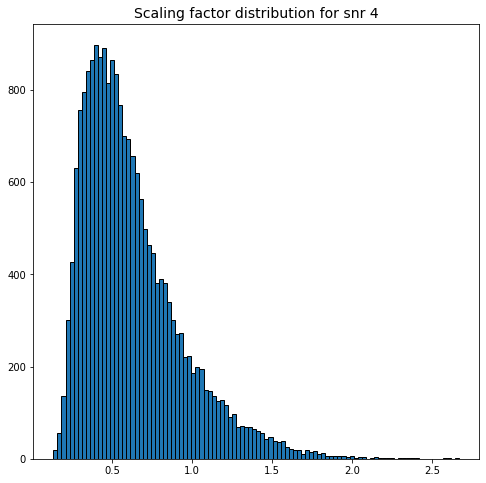

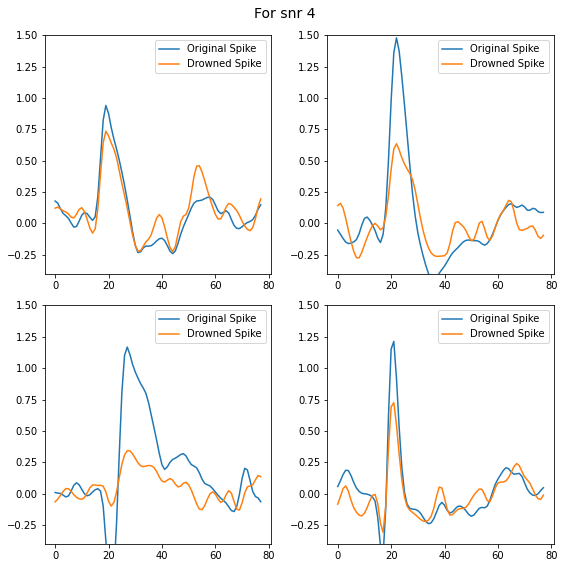

Generating dataset with snr 5


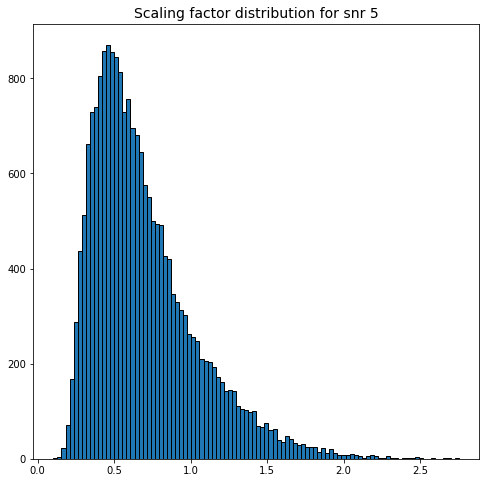

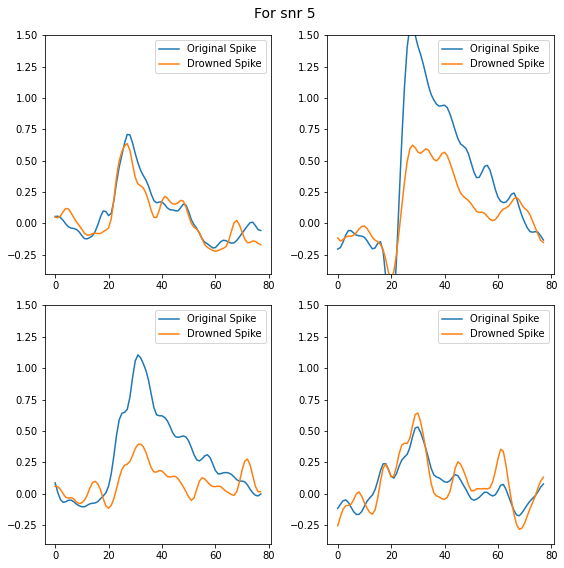

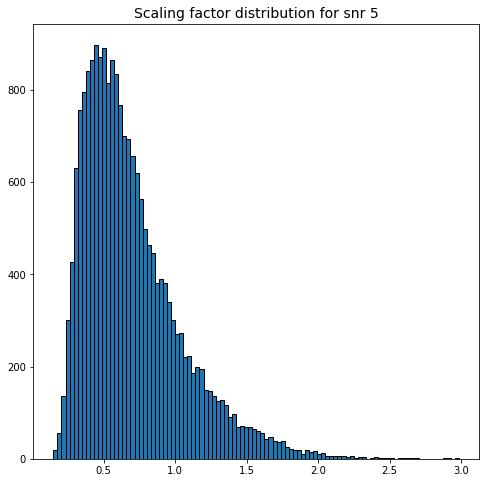

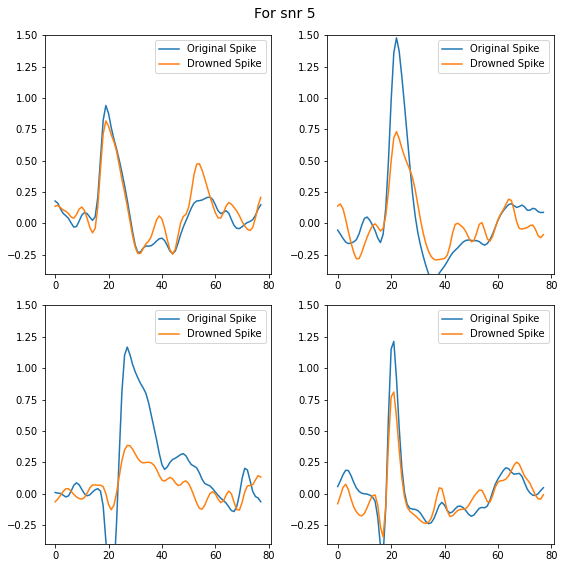

Generating dataset with snr 6


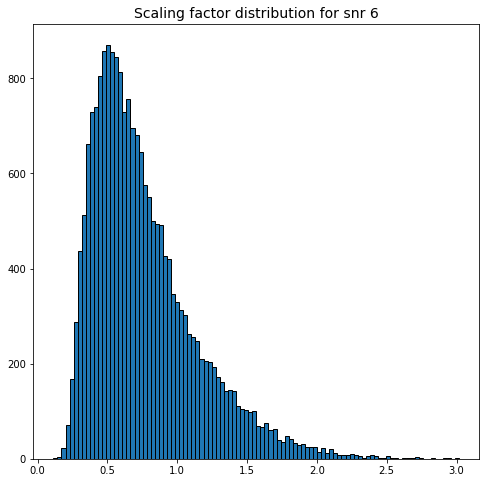

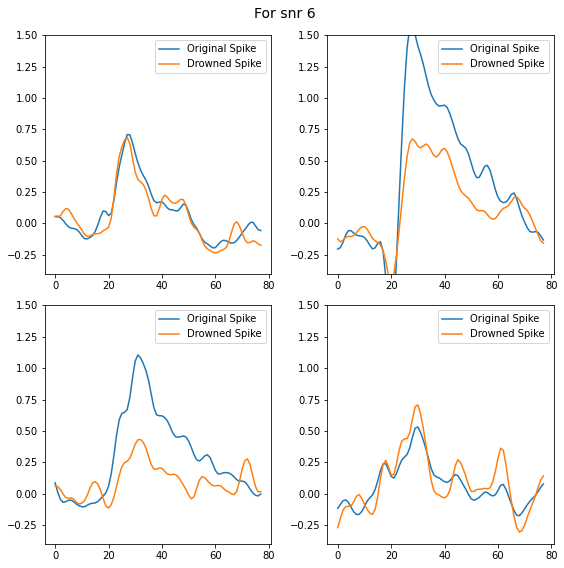

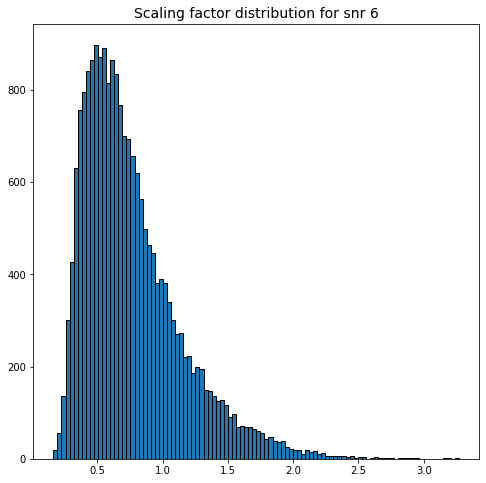

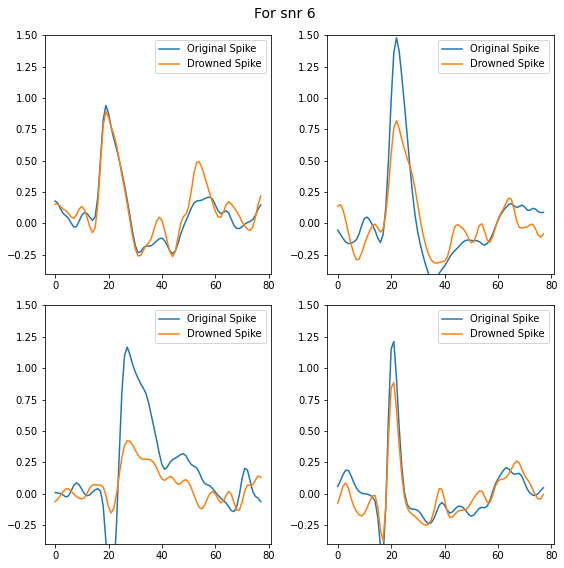

Generating dataset for iteration 7
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


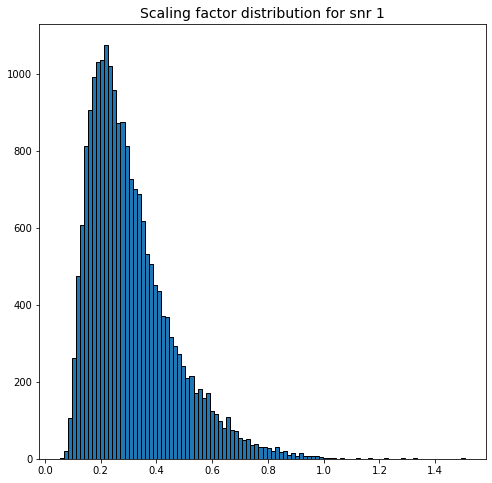

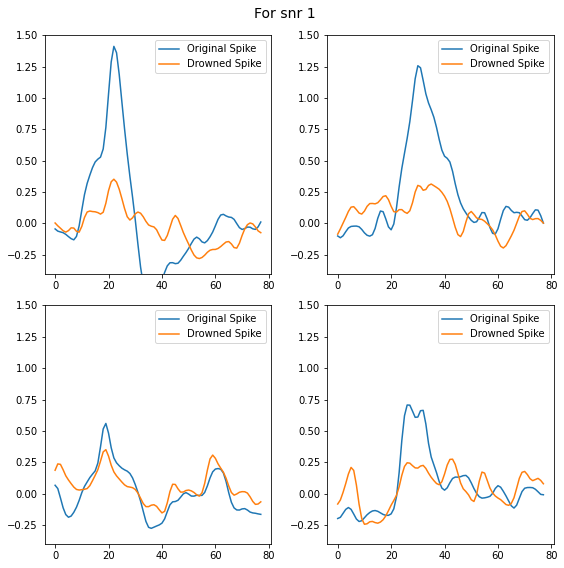

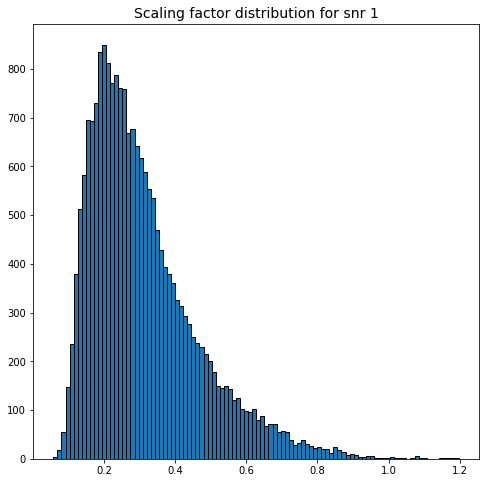

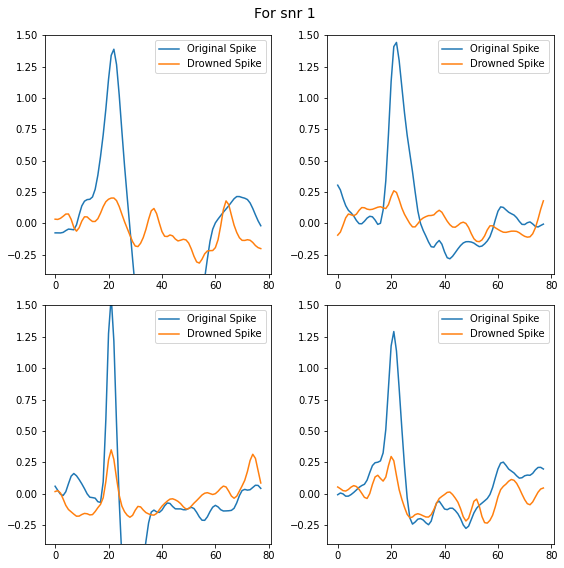

Generating dataset with snr 2


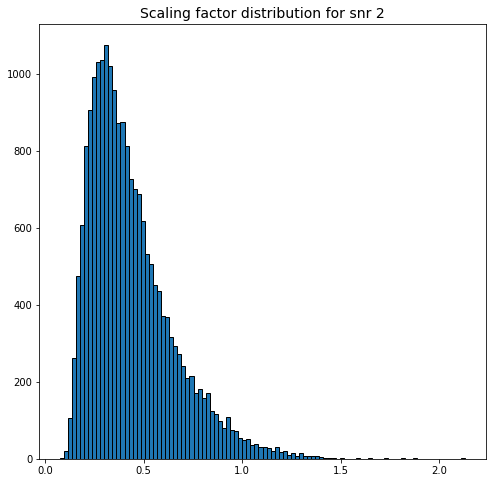

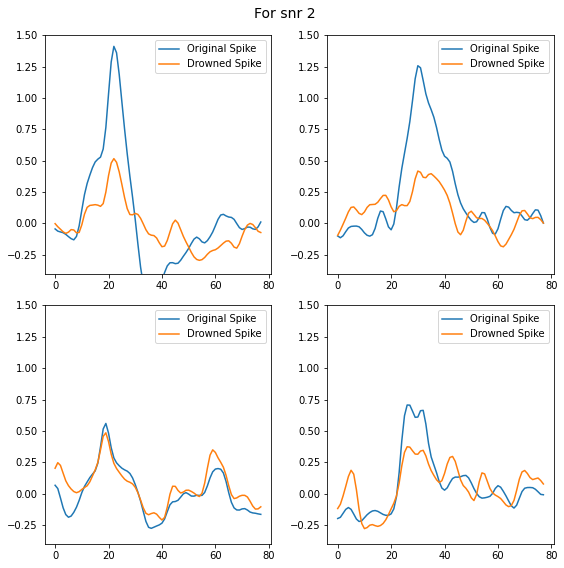

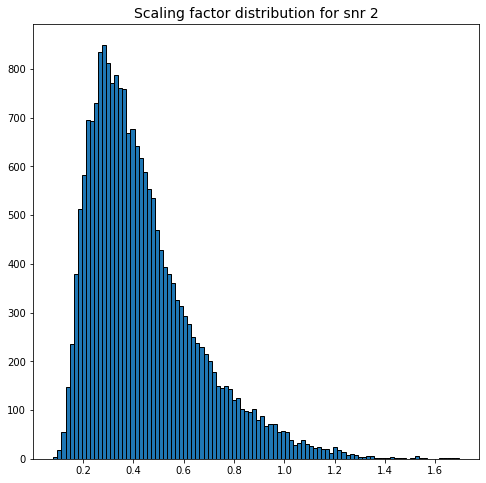

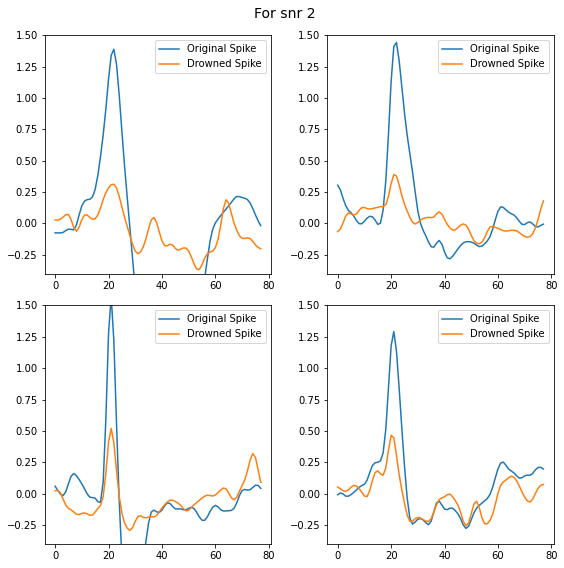

Generating dataset with snr 3


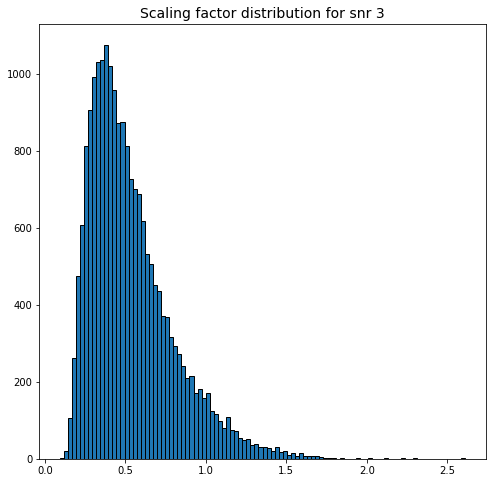

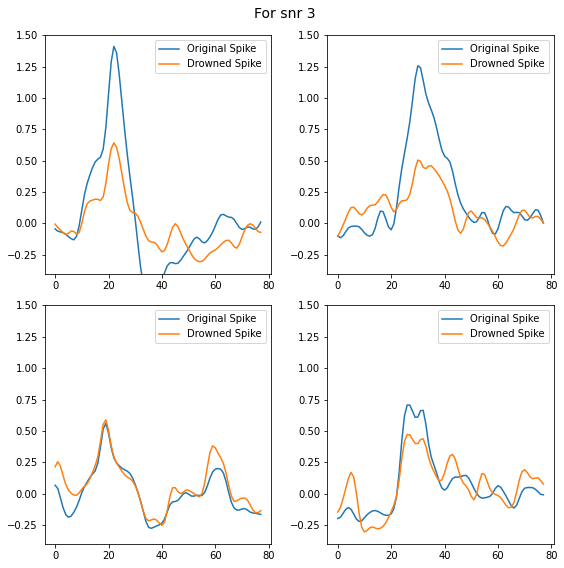

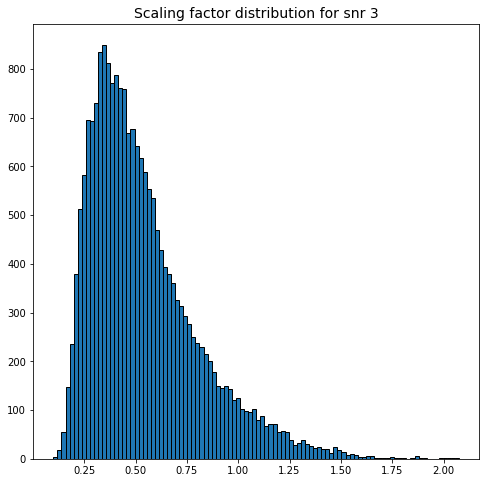

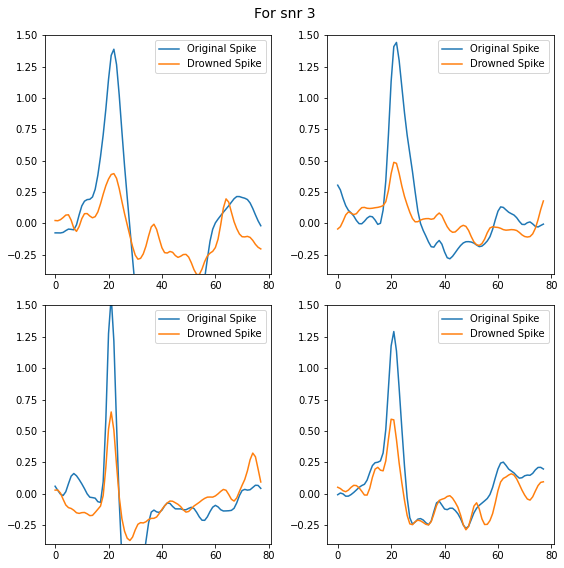

Generating dataset with snr 4


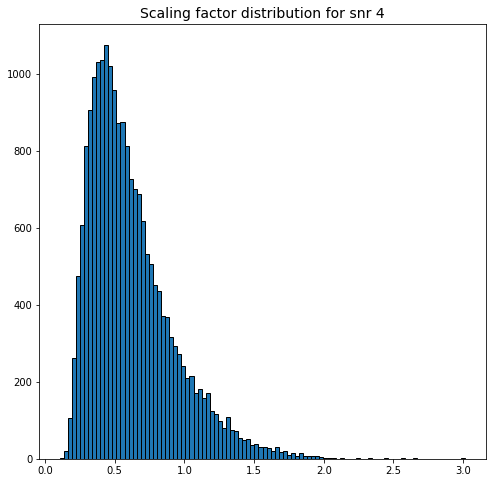

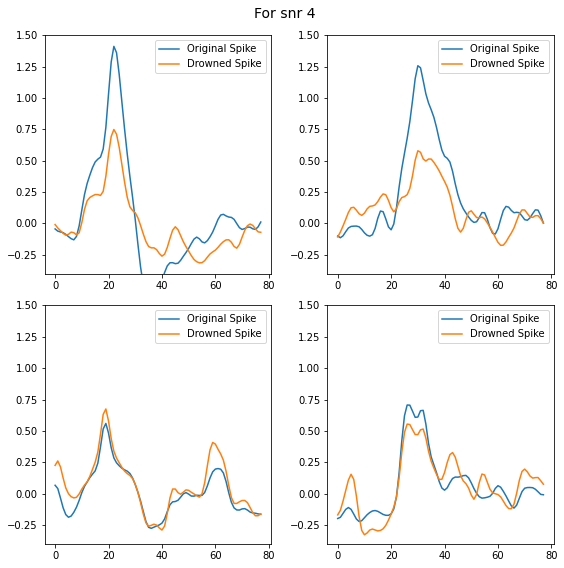

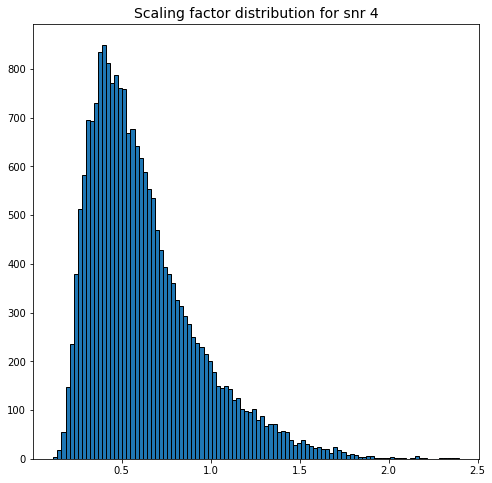

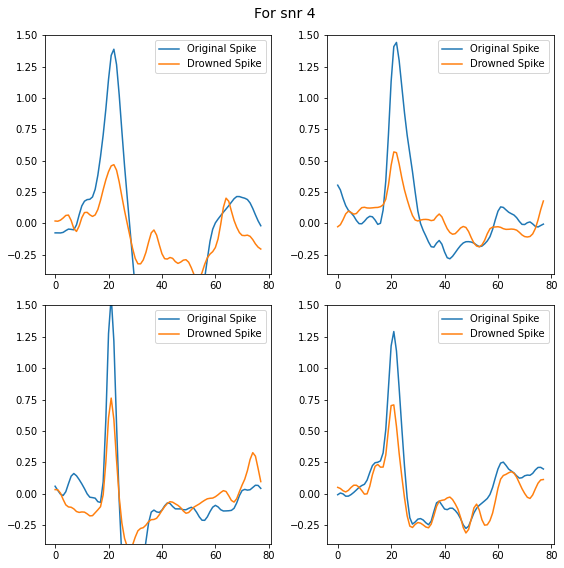

Generating dataset with snr 5


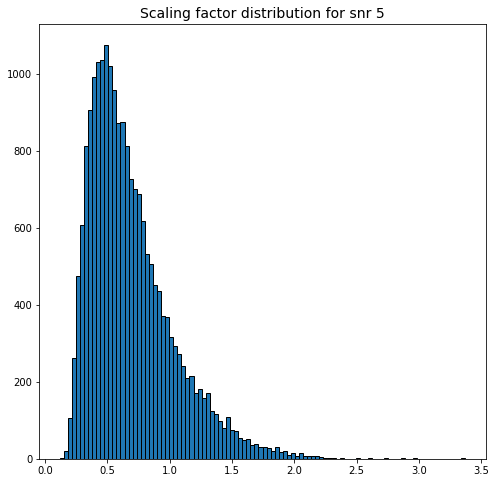

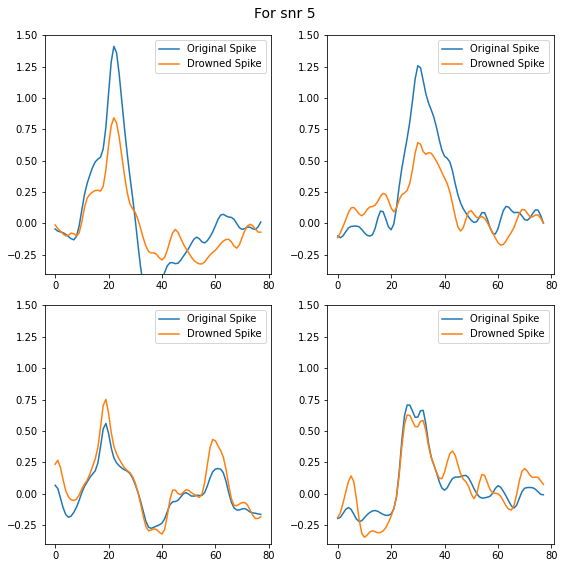

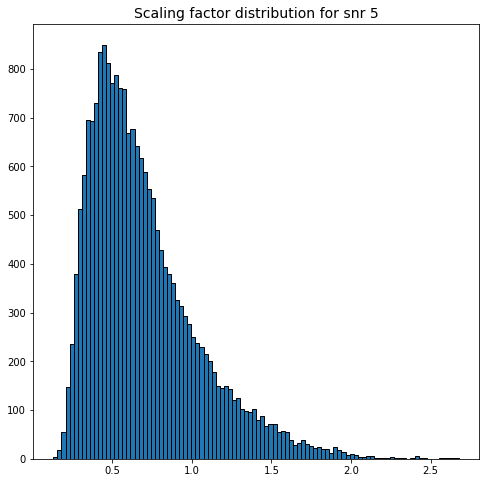

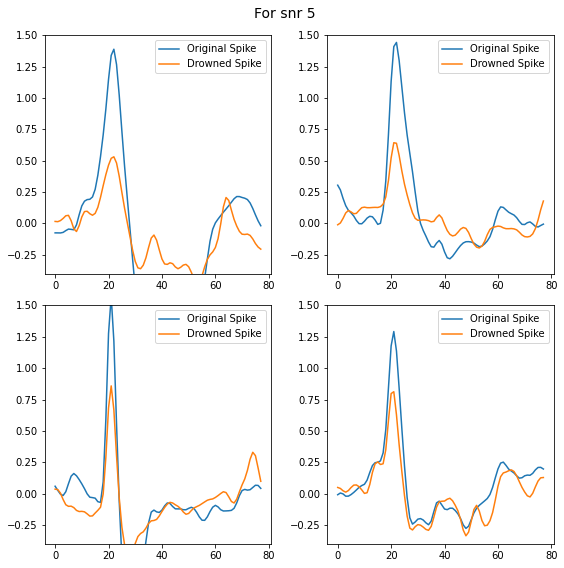

Generating dataset with snr 6


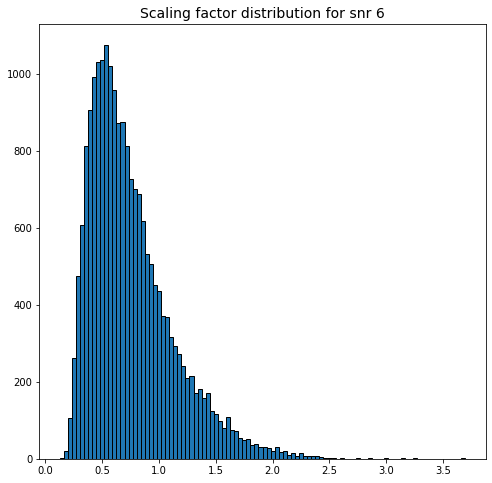

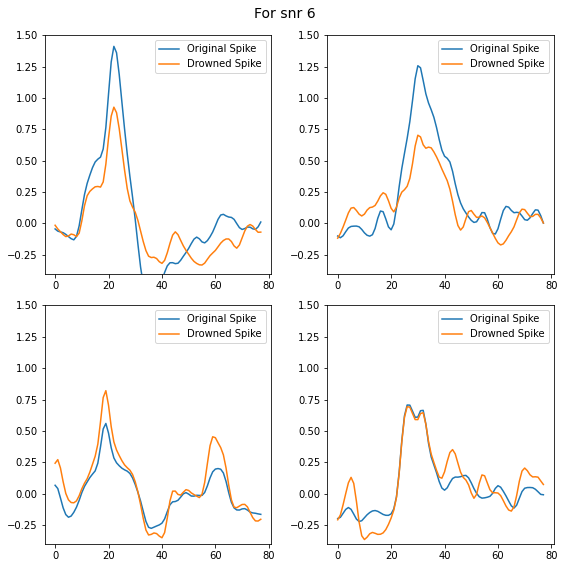

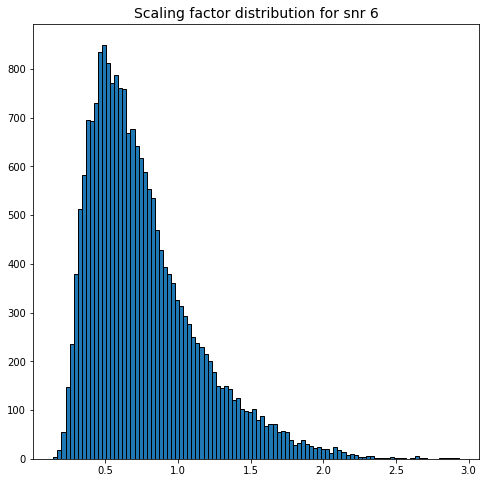

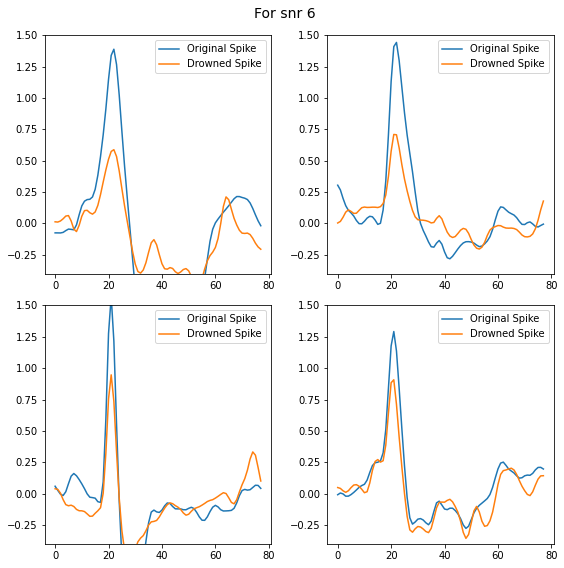

Generating dataset for iteration 8
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


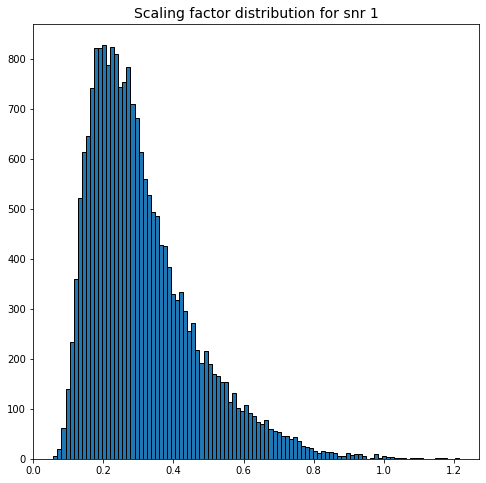

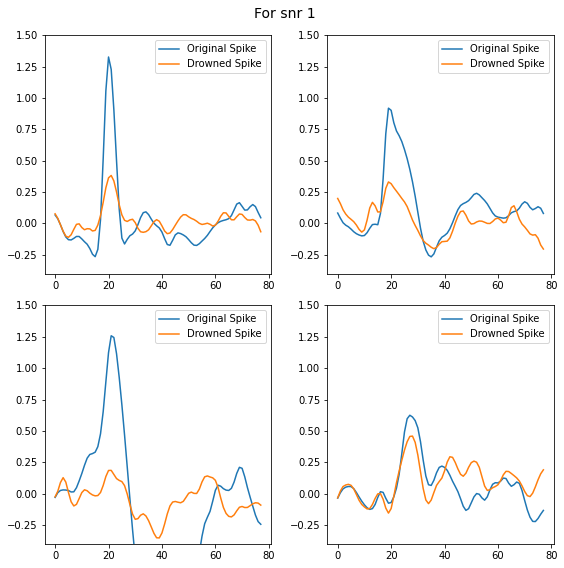

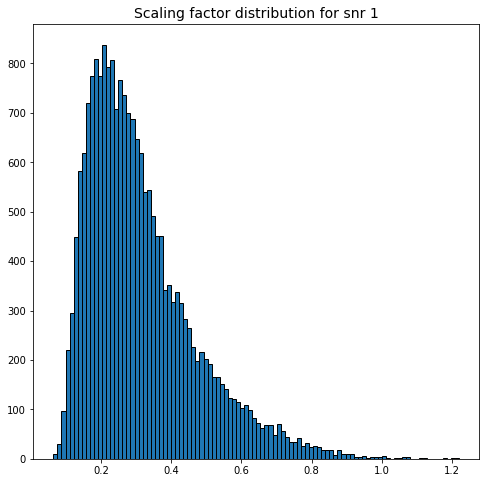

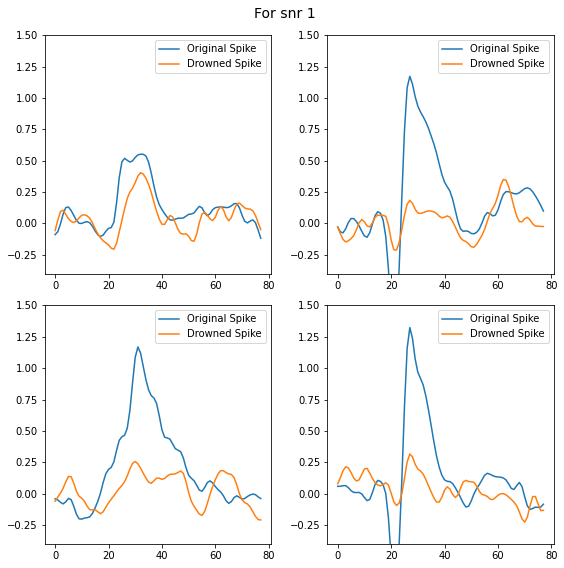

Generating dataset with snr 2


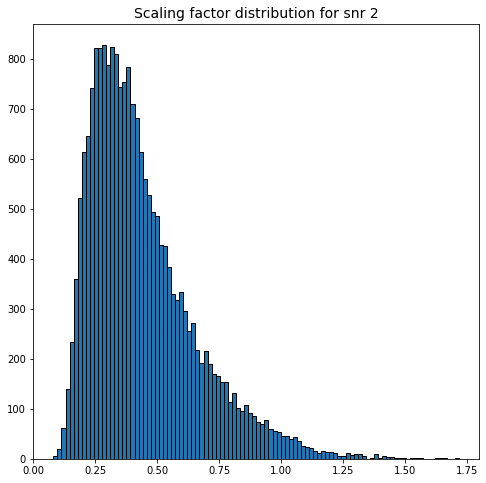

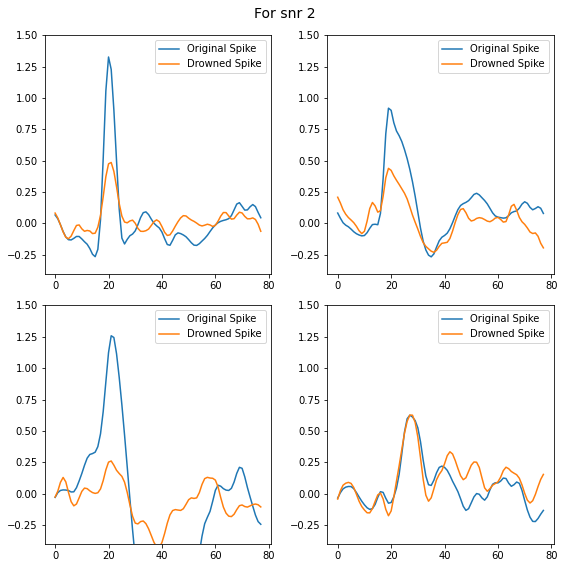

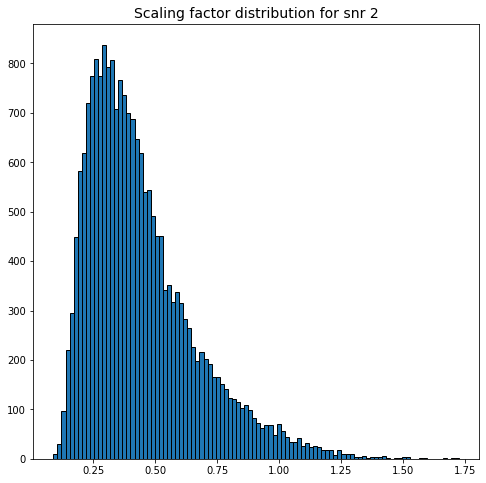

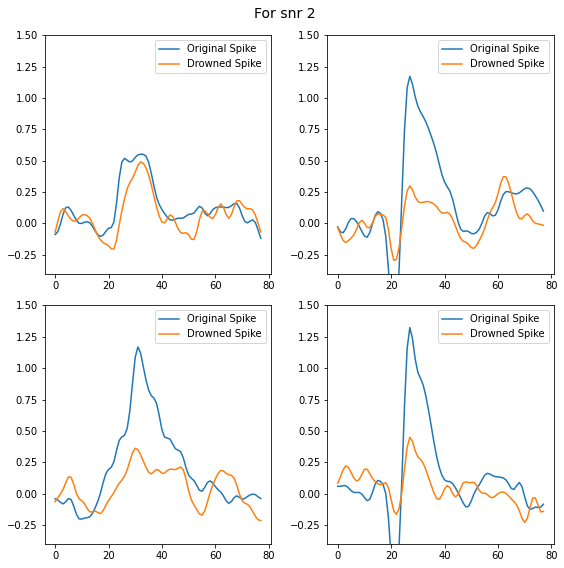

Generating dataset with snr 3


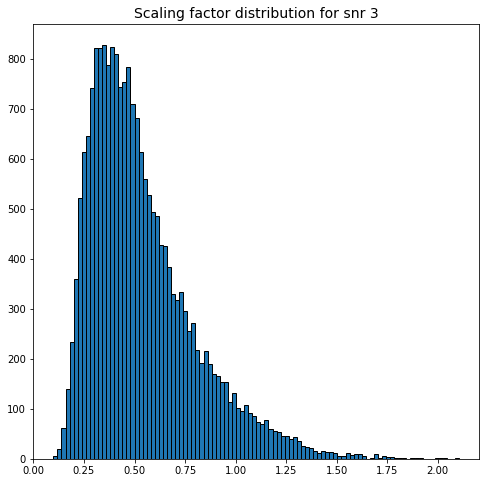

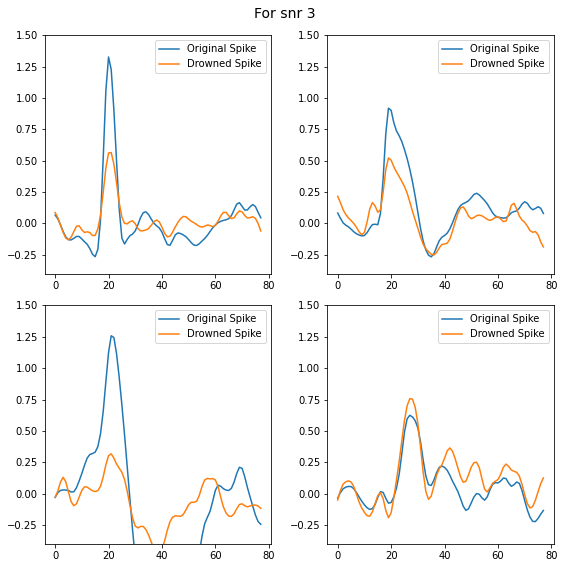

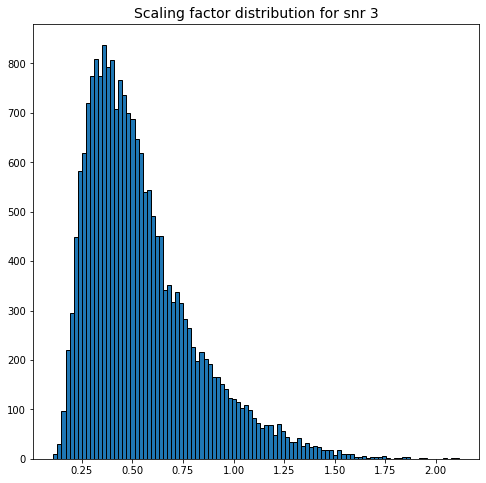

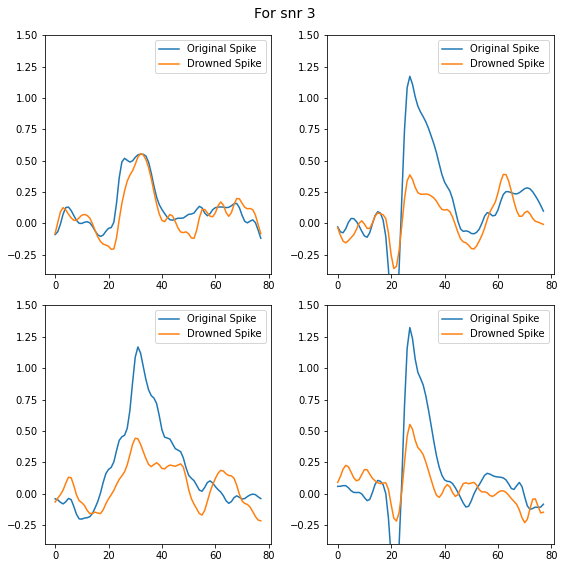

Generating dataset with snr 4


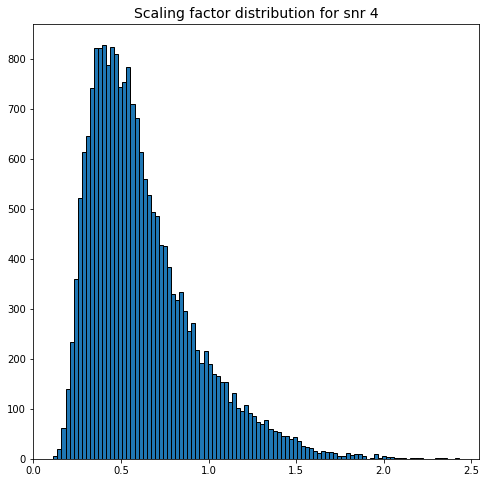

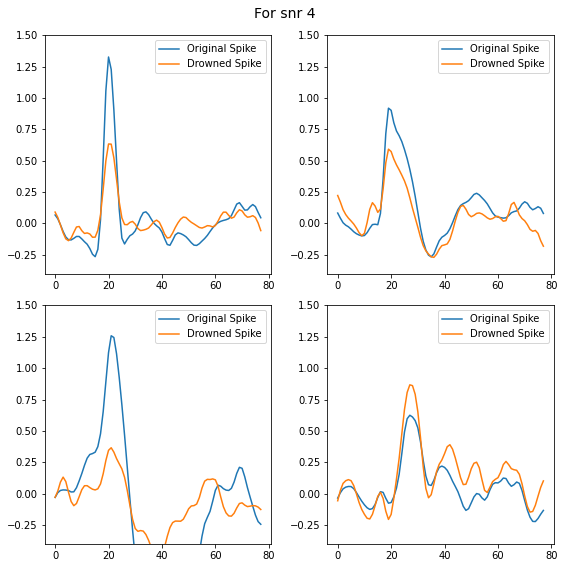

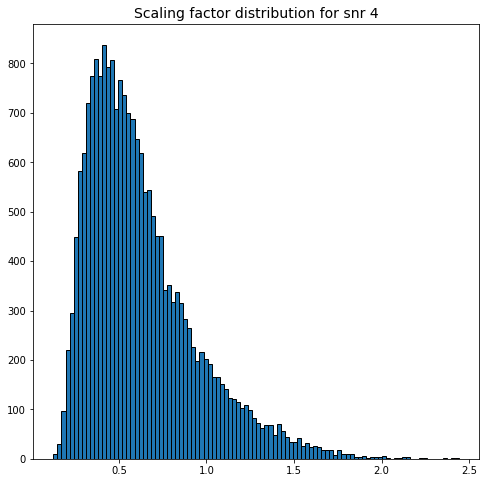

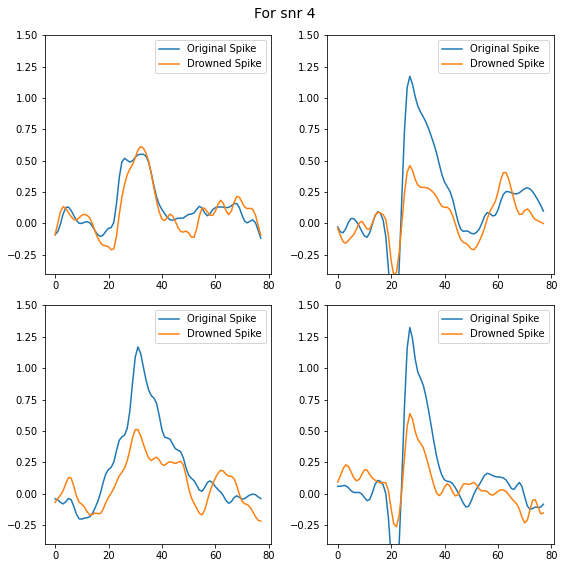

Generating dataset with snr 5


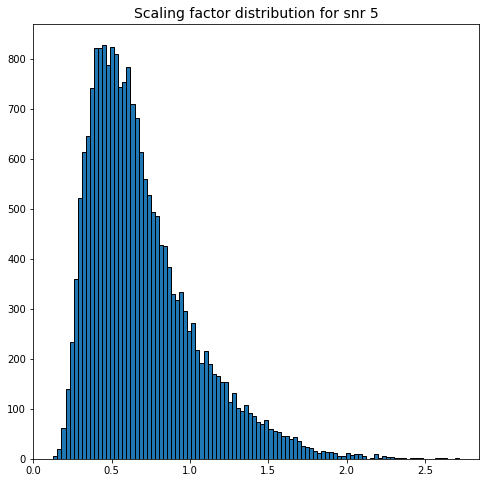

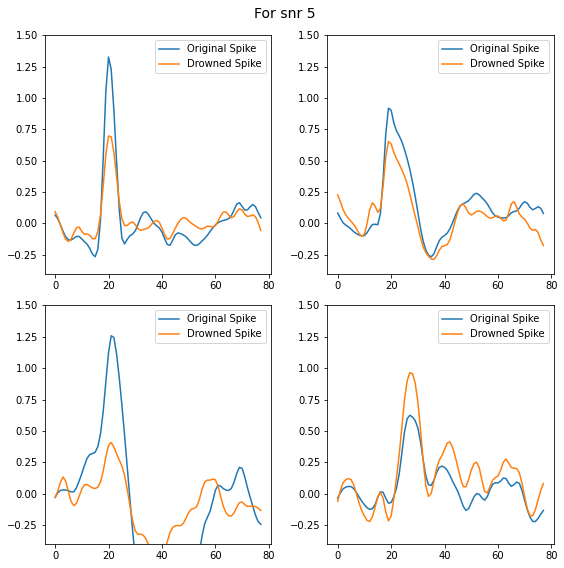

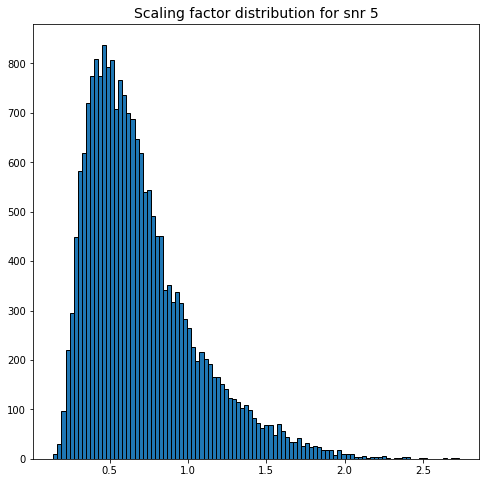

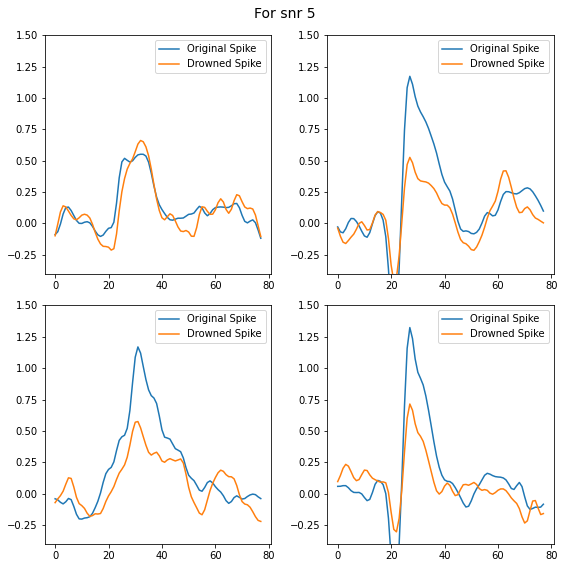

Generating dataset with snr 6


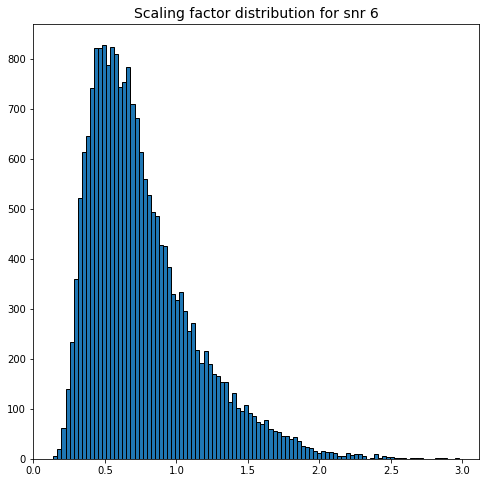

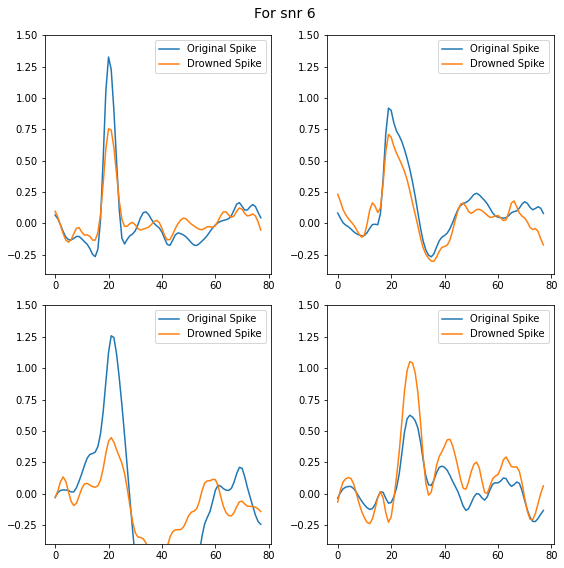

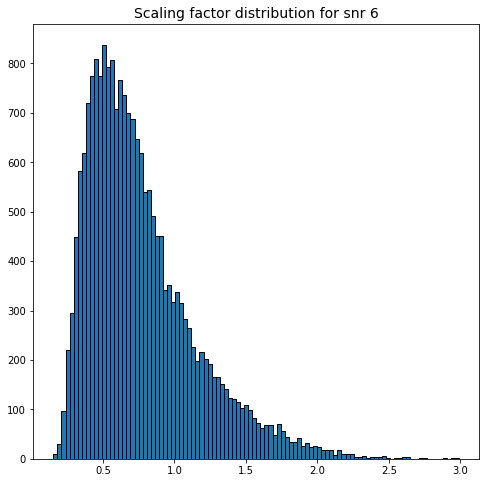

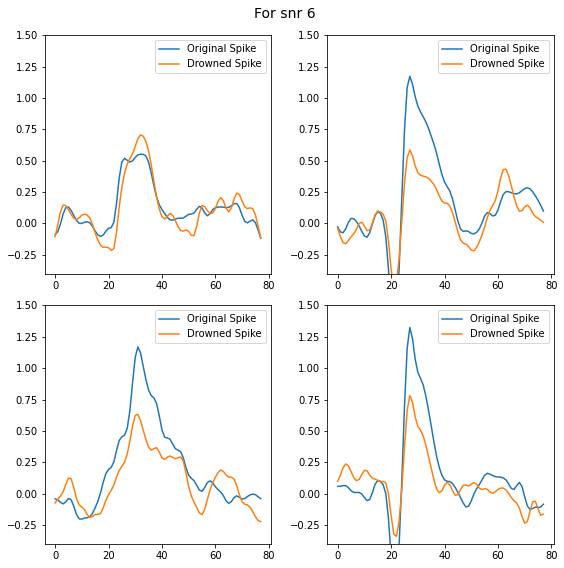

Generating dataset for iteration 9
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


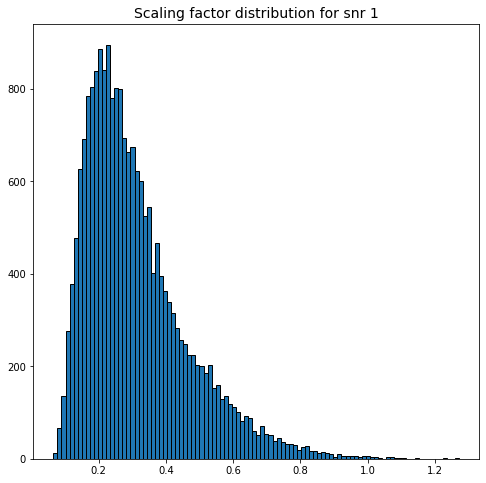

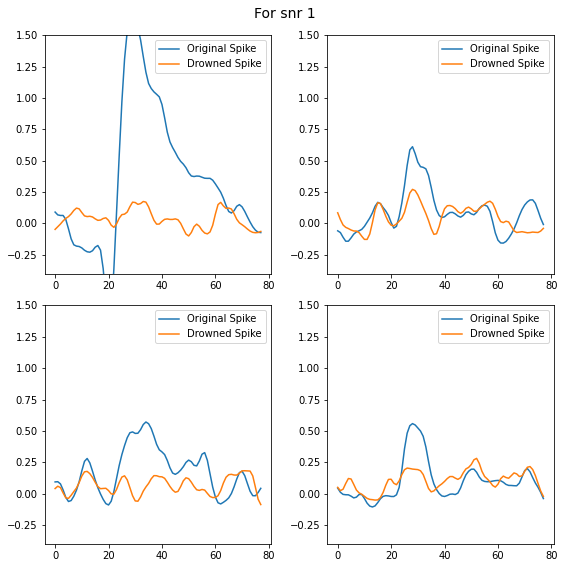

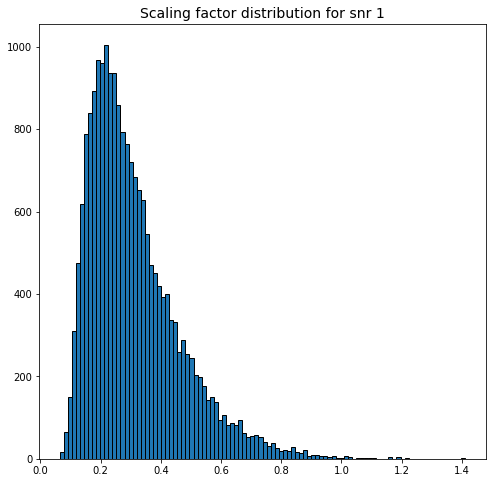

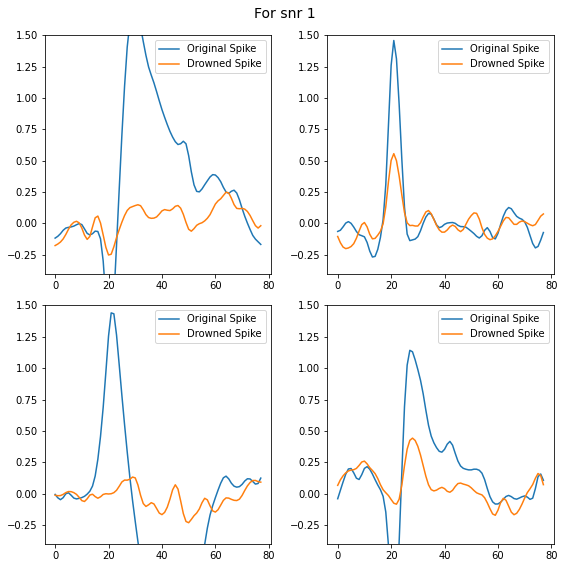

Generating dataset with snr 2


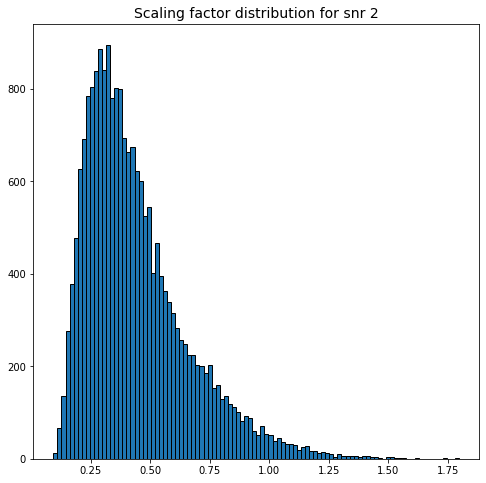

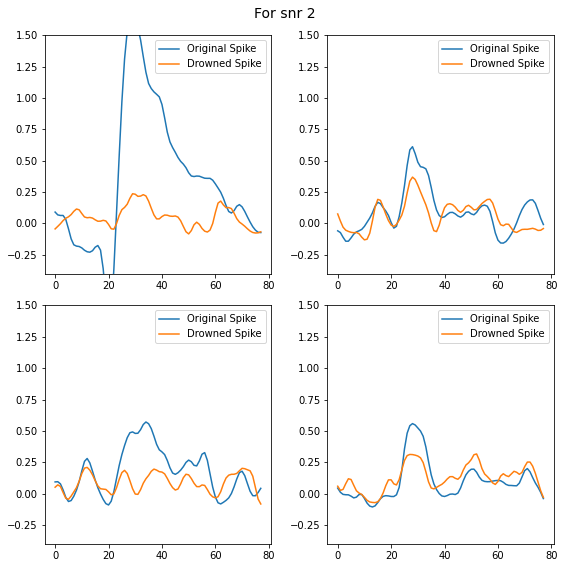

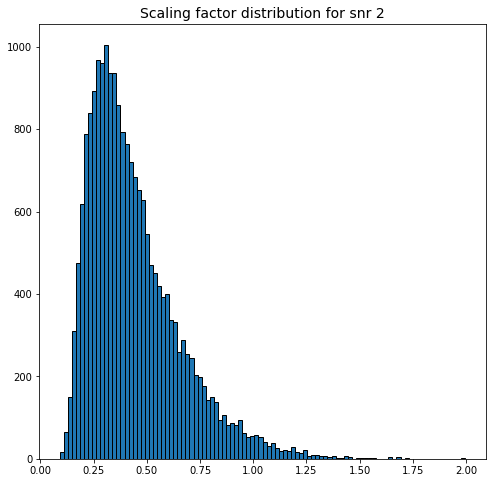

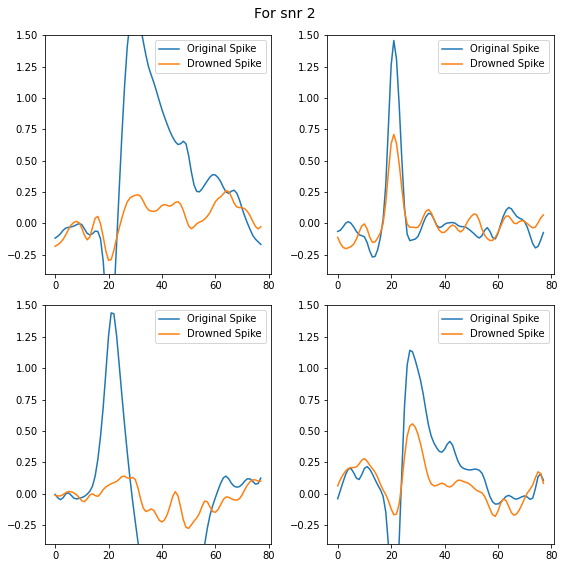

Generating dataset with snr 3


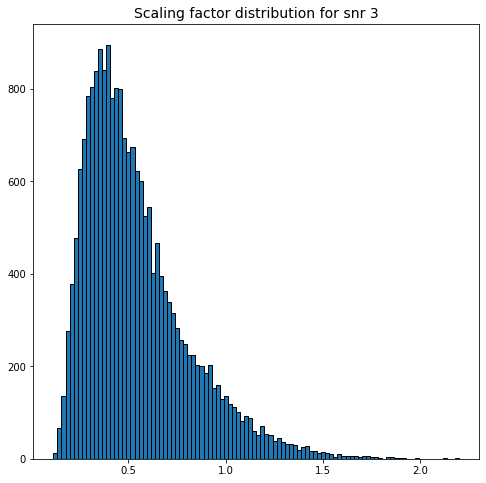

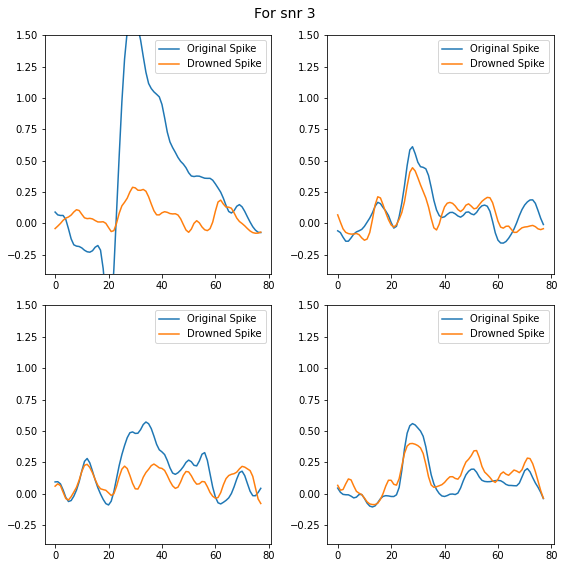

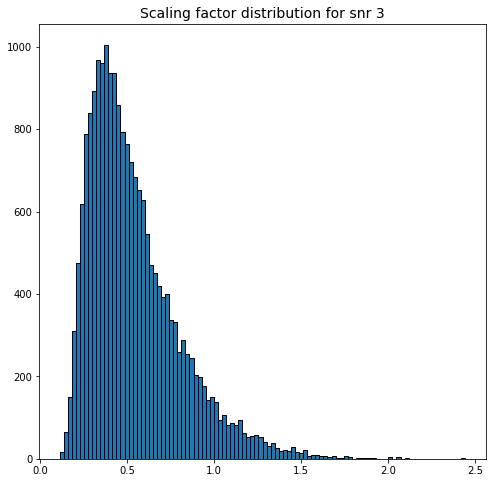

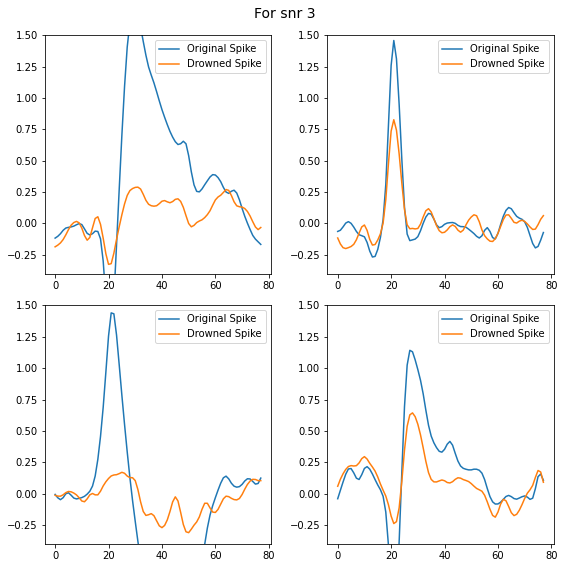

Generating dataset with snr 4


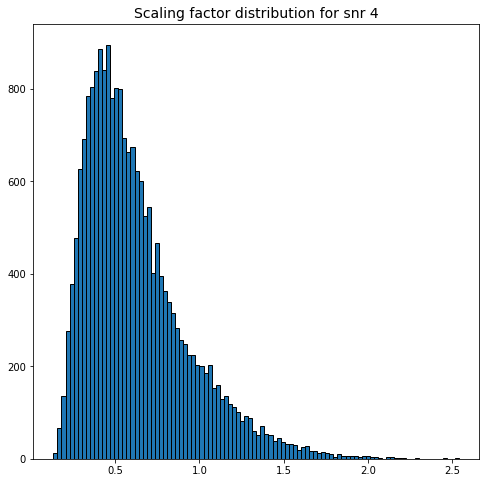

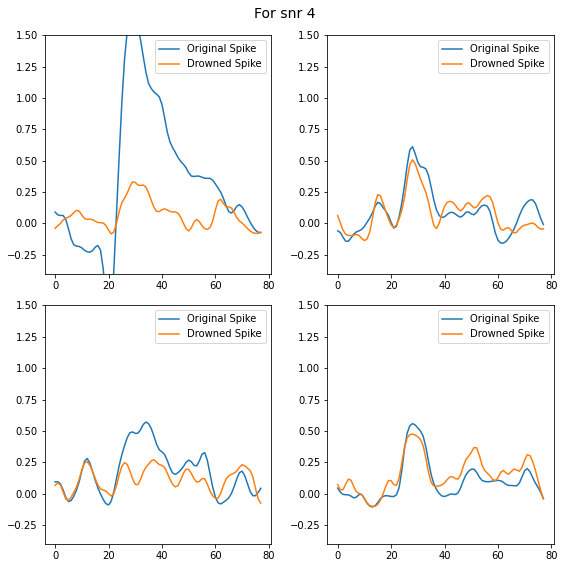

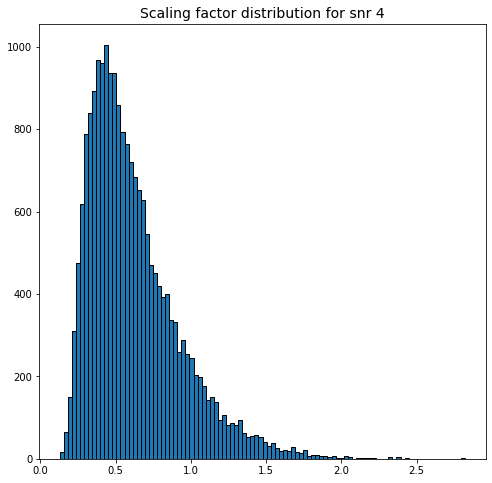

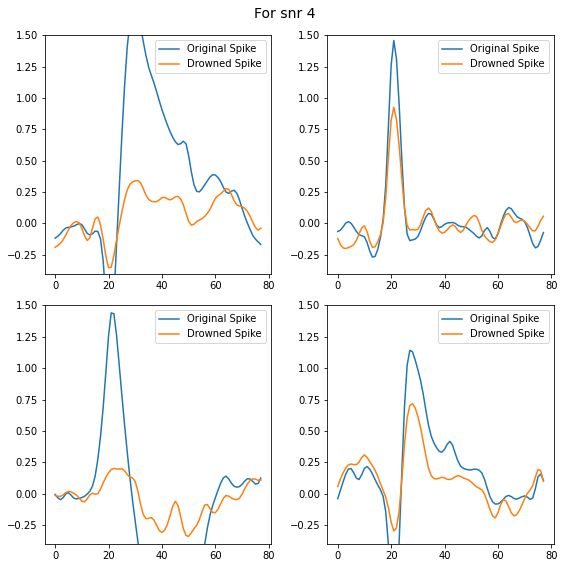

Generating dataset with snr 5


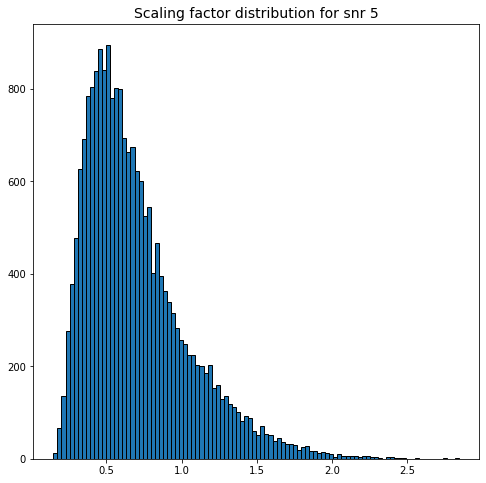

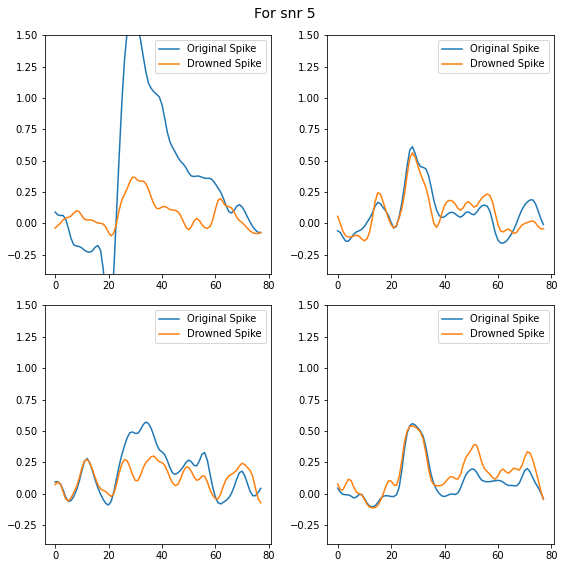

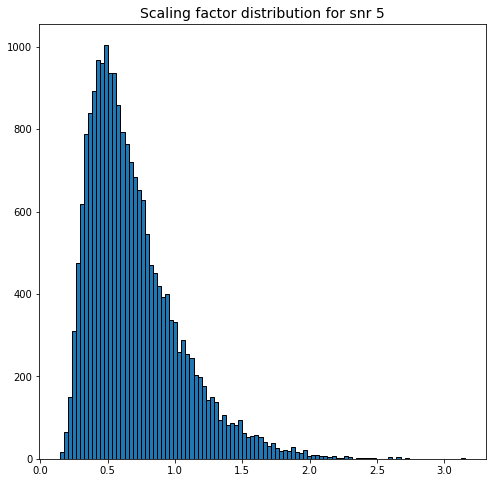

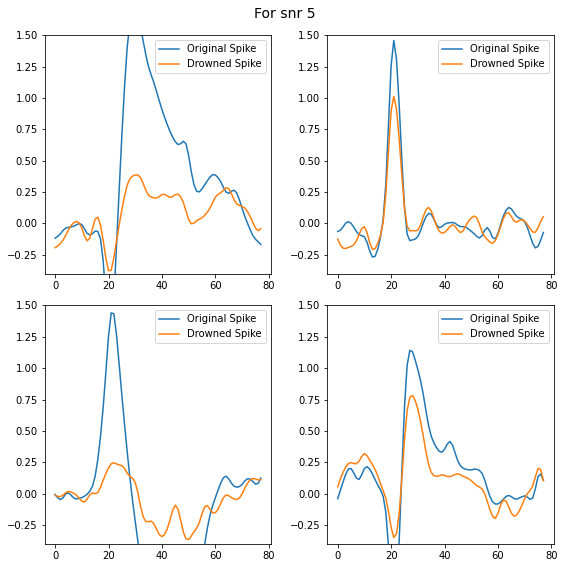

Generating dataset with snr 6


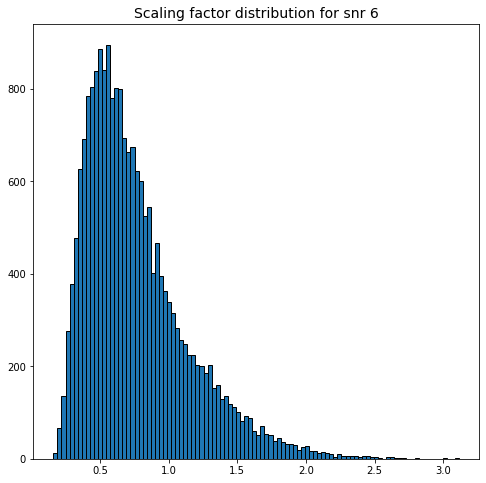

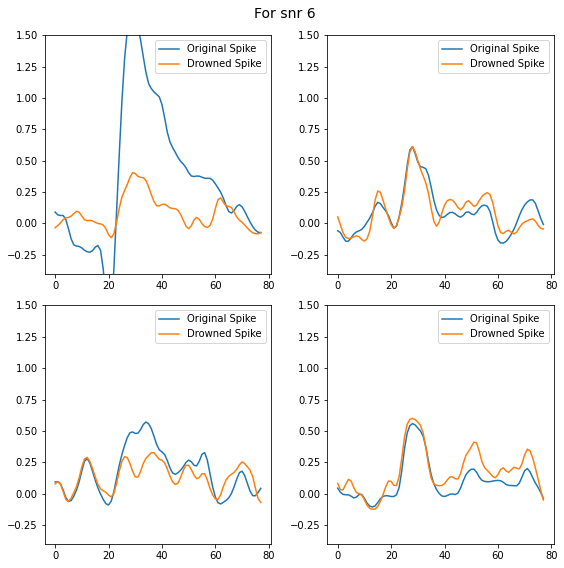

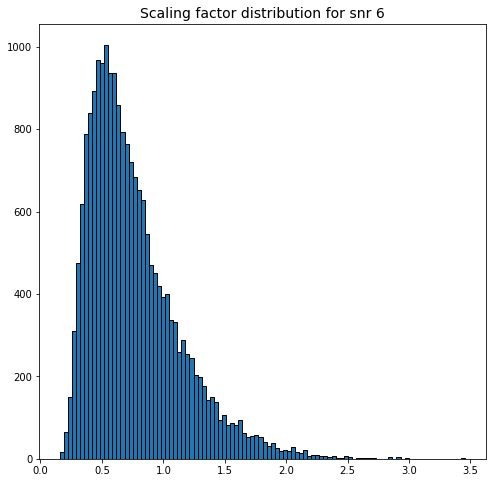

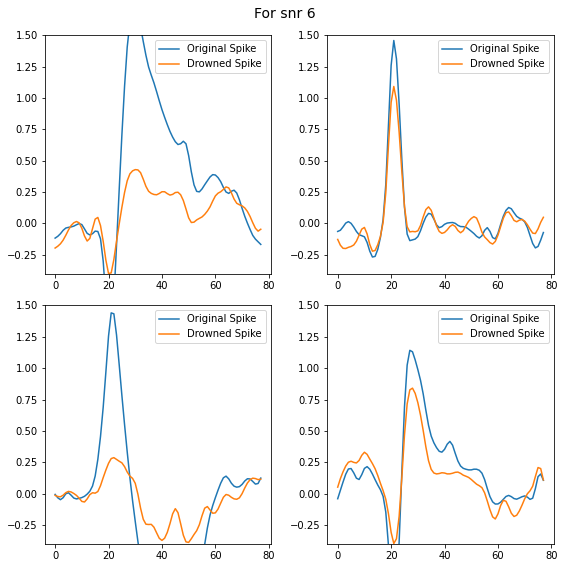

Generating dataset for iteration 10
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


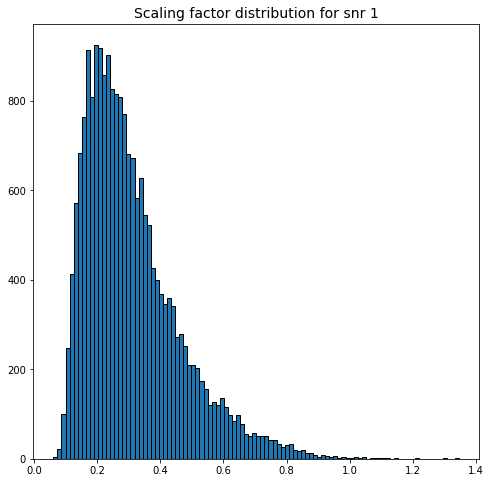

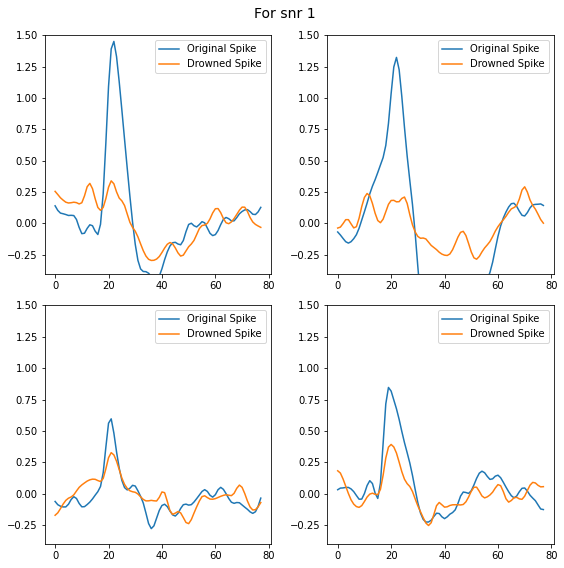

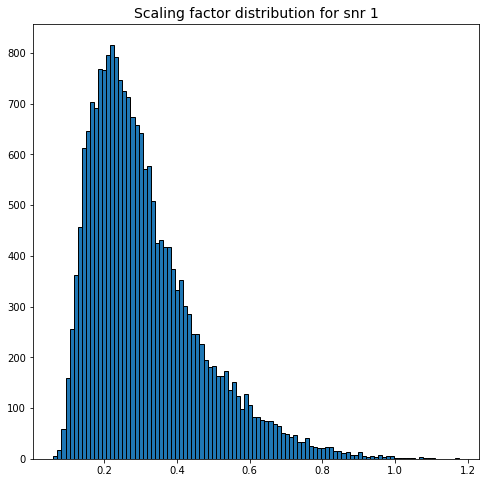

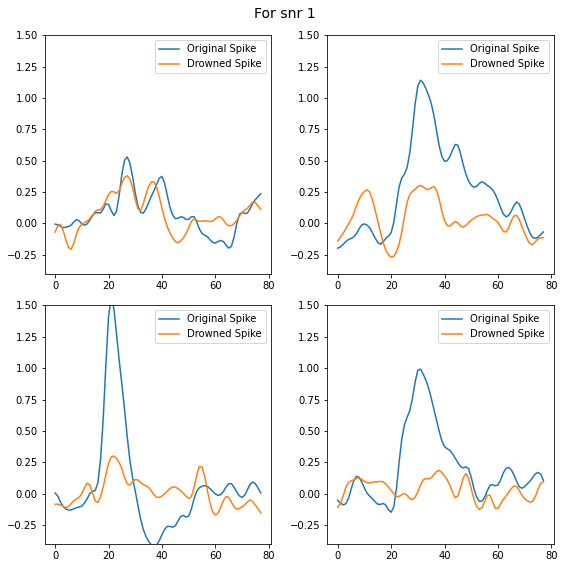

Generating dataset with snr 2


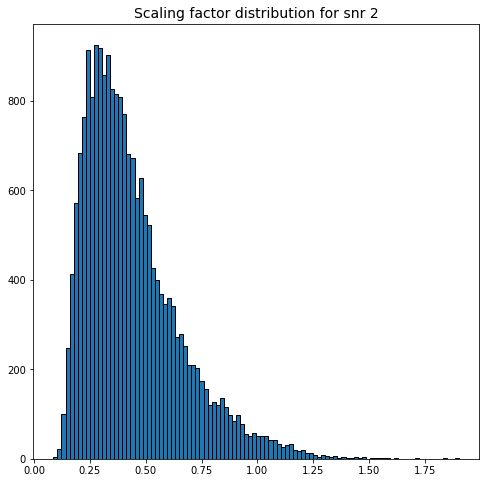

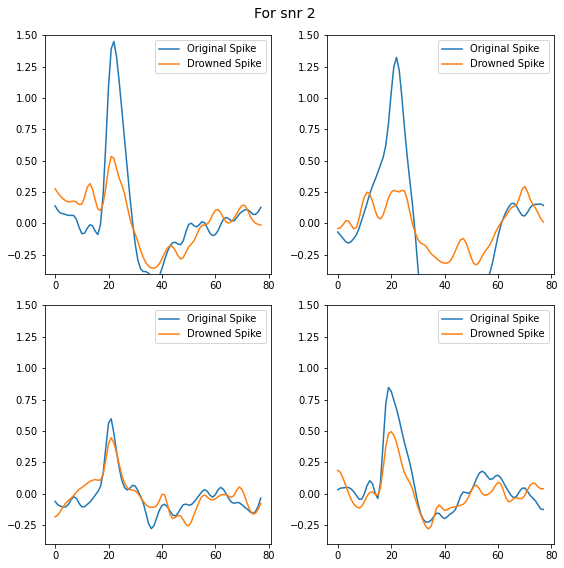

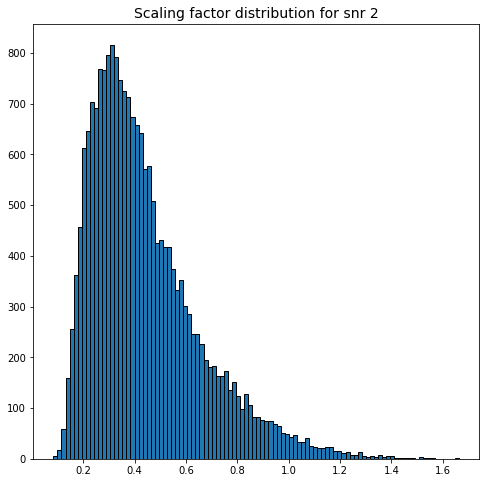

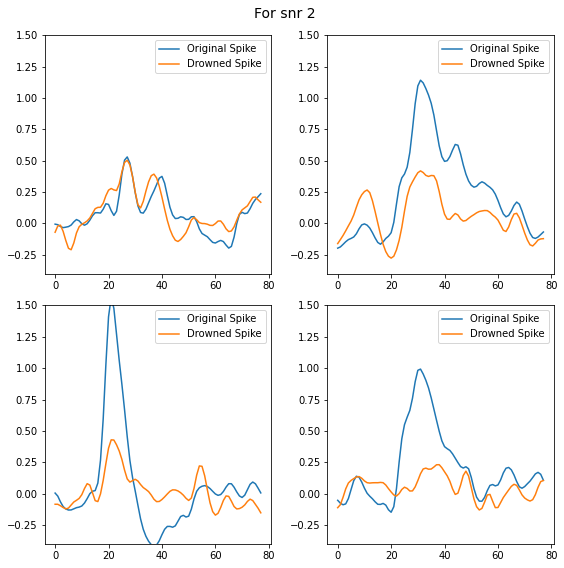

Generating dataset with snr 3


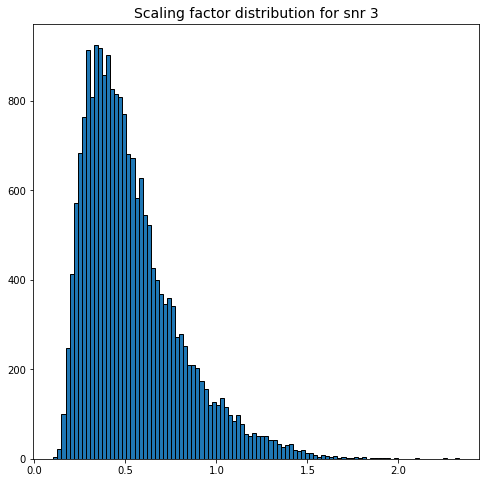

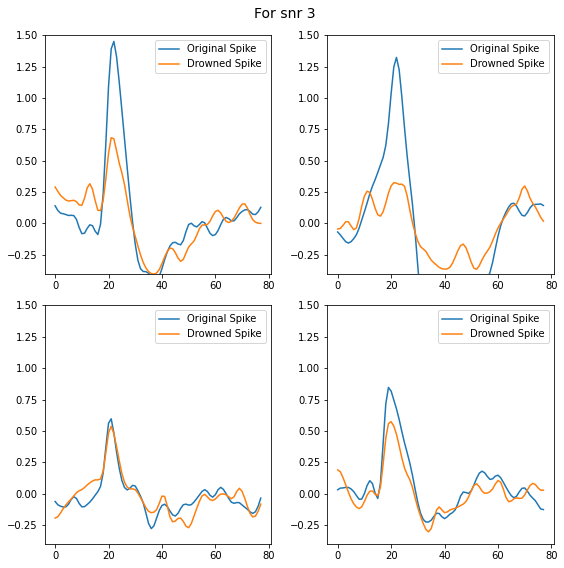

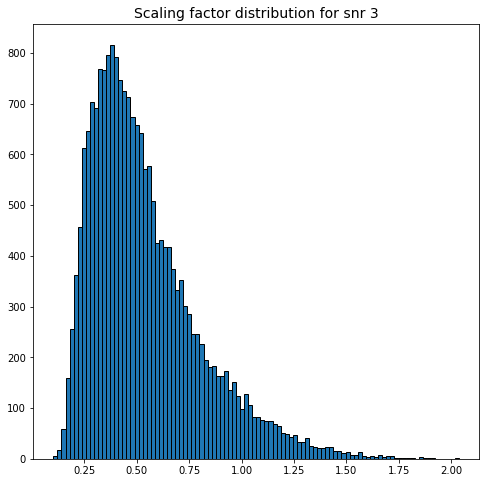

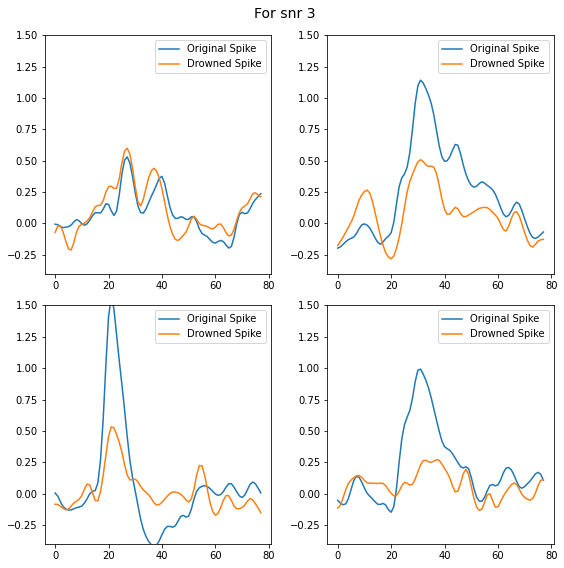

Generating dataset with snr 4


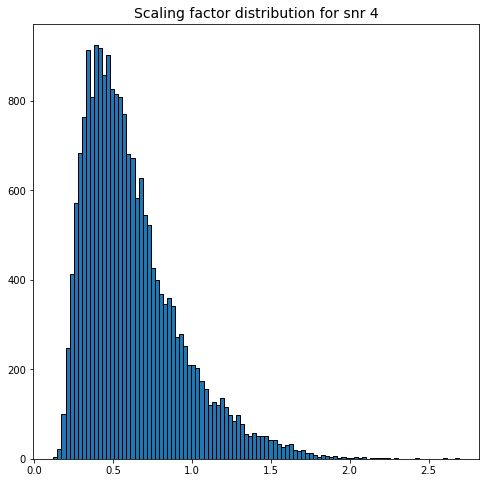

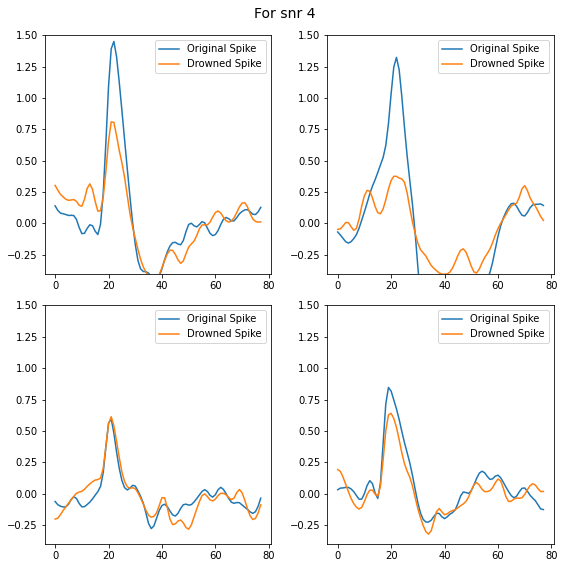

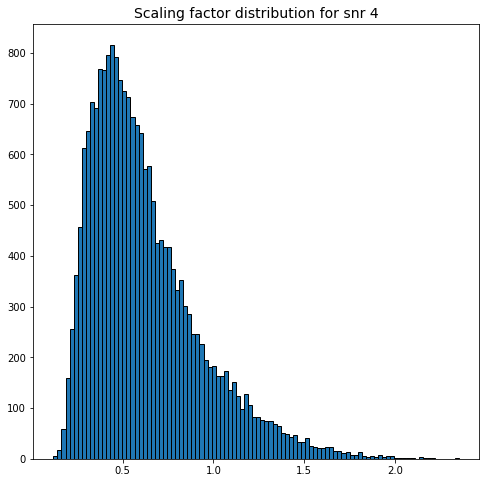

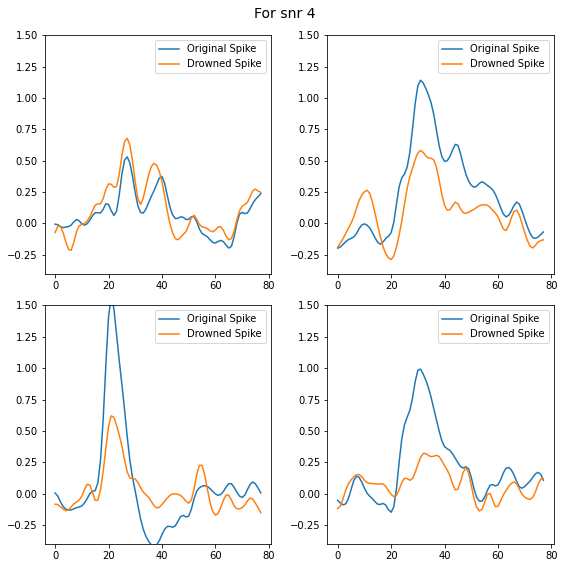

Generating dataset with snr 5


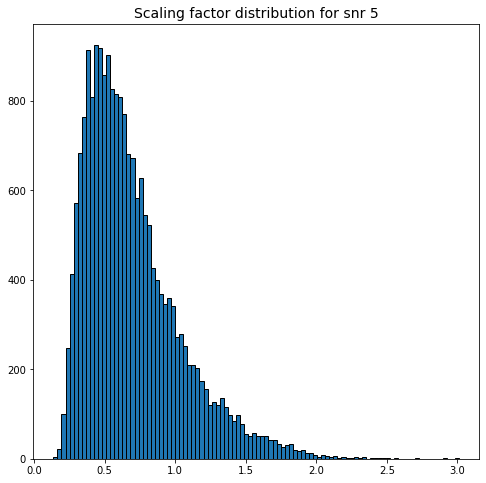

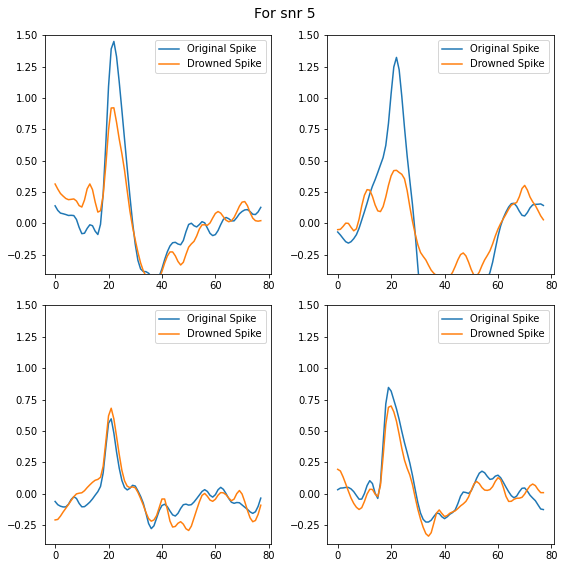

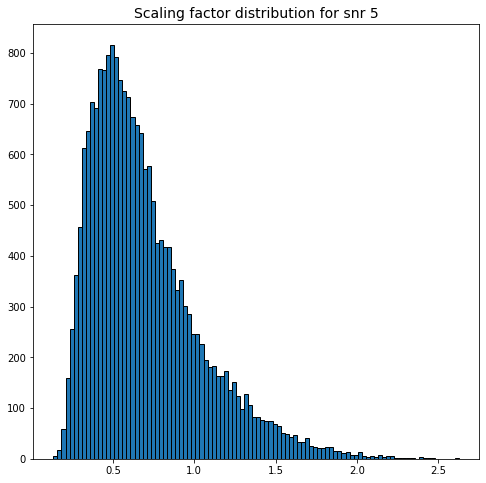

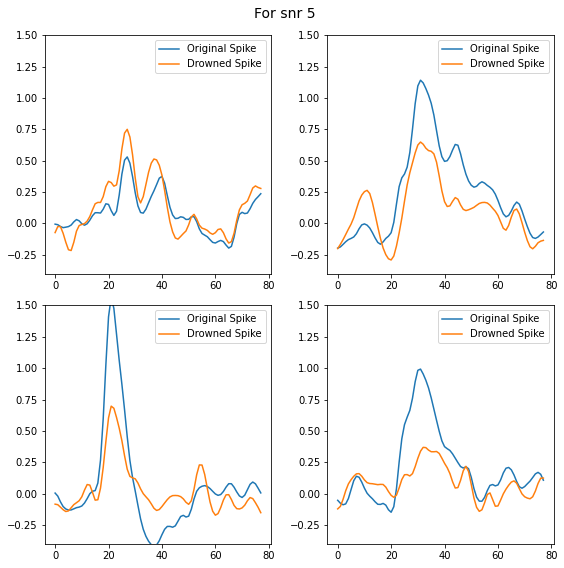

Generating dataset with snr 6


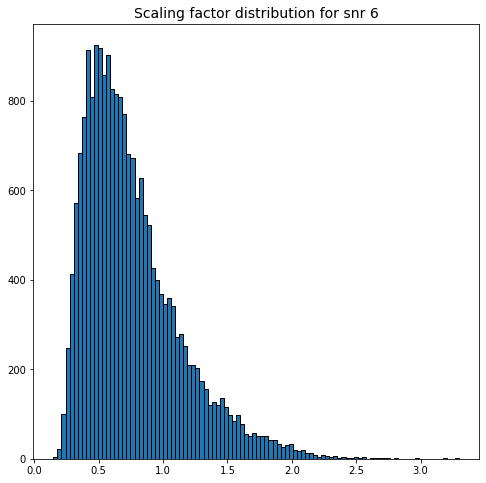

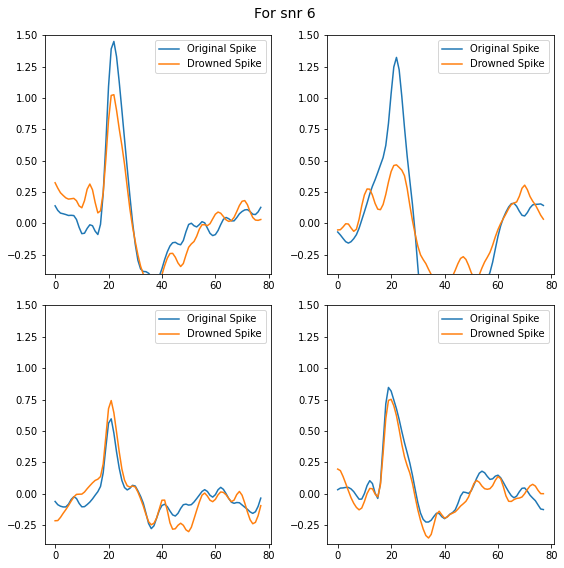

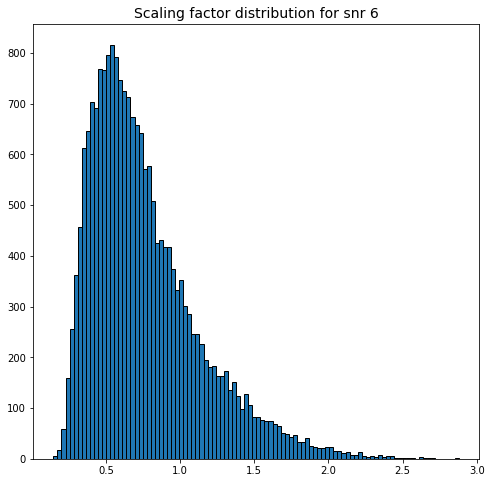

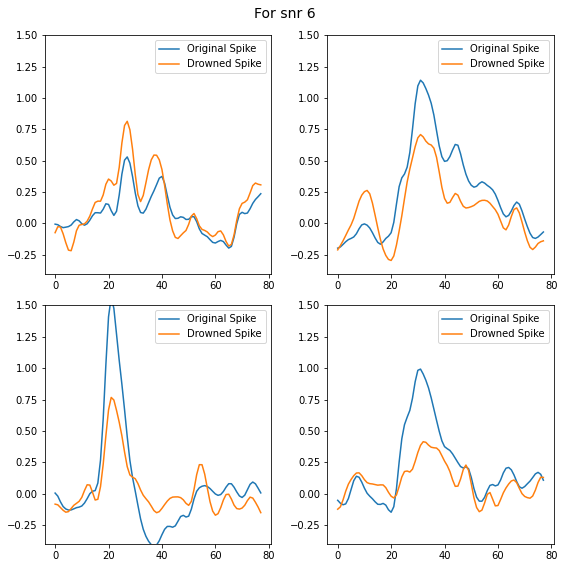

In [14]:
# generate datasets
preprocessing.it_genLoaders( 
    batchSize,
    includedSims,
    doPrint=True,
    snrs=snrs,
    inclusionThreshold=0.5,
    iterations=iters,
    baseDatasetPath=baseDatasetPath
)

In [15]:
# run thresholding pipeline iters times

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

thresholdingRes = defaultdict(thresholdDefault1)

means = [0,0,0,0,0,0,0]
sds = [0,0,0,0,0,0,0]


for i in iters:
    print(f"\nIteration {i}\n")
    
    trainSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainSpikesLoader.pickle", "rb"))
    trainBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainBgLoader.pickle", "rb"))
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    for snr in snrs:
        print(f"\nThresholding dataset with snr {snr}\n")

        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))

        mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)
        means[snr] += mean
        sds[snr] += sd
        
        for sdMul in sdMuls:
            pred = thresholding.thresholdDatasets(mean, sdMul * sd, testSpikesLoader, testBgLoader)

            labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

            confusionMatrix = testingPipeline.confusionMatrix(labels,pred)

            accuracy, sensitivity, specificity, f1 = testingPipeline.metrics(confusionMatrix)

            thresholdingRes[i][sdMul][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

            print(f"Results for {sdMul} sd")
            print(confusionMatrix)
            print(f"Accuracy: {accuracy}")
            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")

#pickle.dump(dict(thresholdingRes), open(f"{resultsPath}/thresholdingRes2.pickle", "wb"))



Iteration 1


Thresholding dataset with snr 1

Results for 1 sd
[[ 4260 16394]
 [ 1087 19567]]
Accuracy: 0.5768132080952842
Sensitivity: 0.9473709693037669
Specificity: 0.20625544688680159
Results for 2 sd
[[16944  3710]
 [10121 10533]]
Accuracy: 0.6651738162099351
Sensitivity: 0.5099738549433523
Specificity: 0.8203737774765179
Results for 3 sd
[[20152   502]
 [16983  3671]]
Accuracy: 0.5767163745521449
Sensitivity: 0.17773796843226494
Specificity: 0.9756947806720248
Results for 4 sd
[[20606    48]
 [19437  1217]]
Accuracy: 0.5282996029824731
Sensitivity: 0.0589232110002905
Specificity: 0.9976759949646558
Results for 5 sd
[[20647     7]
 [20250   404]]
Accuracy: 0.5096107291565798
Sensitivity: 0.01956037571414738
Specificity: 0.9996610825990123

Thresholding dataset with snr 2

Results for 1 sd
[[ 4358 16296]
 [  226 20428]]
Accuracy: 0.6000290500629418
Sensitivity: 0.9890578096252541
Specificity: 0.2110002905006294
Results for 2 sd
[[17042  3612]
 [ 6131 14523]]
Accuracy: 0.764137697

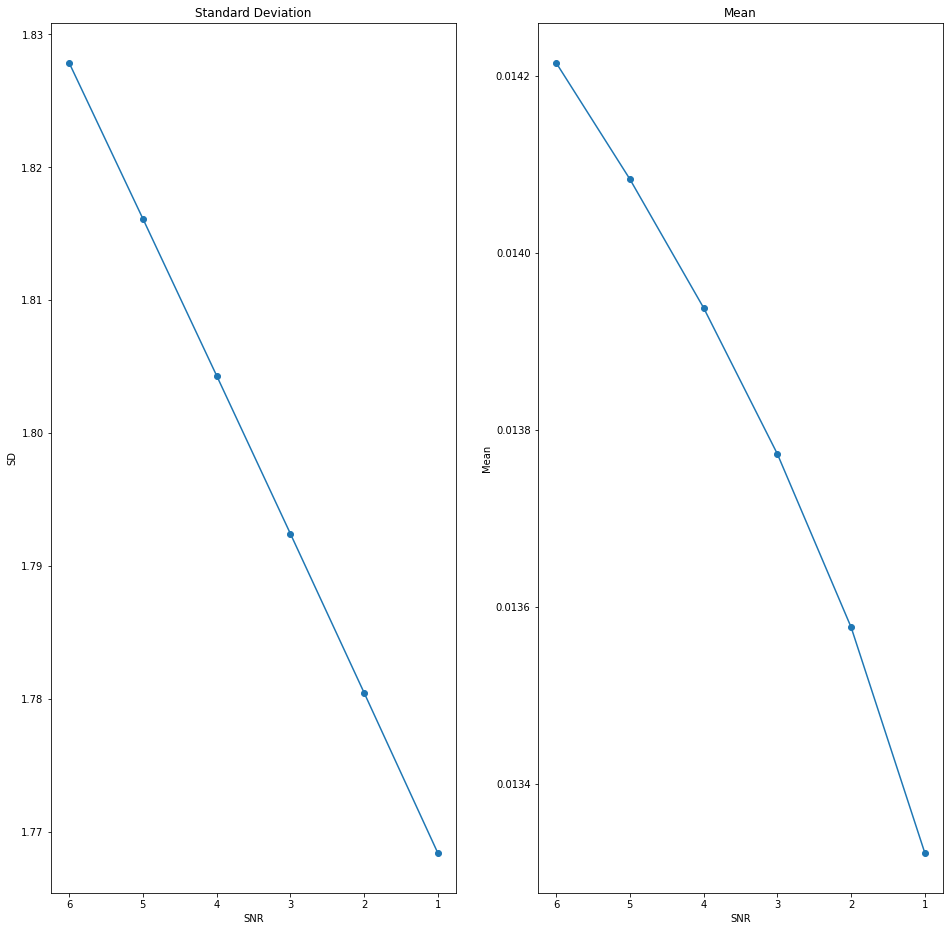

In [15]:
plt.rcParams['figure.figsize'] = [16, 16]     
fig, axs = plt.subplots(1,2)

axs[0].title.set_text("Standard Deviation")
axs[1].title.set_text("Mean")
axs[0].set_xlabel("SNR")
axs[1].set_xlabel("SNR")
axs[0].set_ylabel("SD")
axs[1].set_ylabel("Mean")

axs[0].plot(snrs, sds[1:],  marker='o')
axs[1].plot(snrs, means[1:], marker='o')


axs[0].invert_xaxis()
axs[1].invert_xaxis()

plt.savefig('sd-mean.png', facecolor='w')
plt.show()
plt.rcParams['figure.figsize'] = [16, 8]    

In [3]:
# run the separation pipeline iters times

def defaultSep():
    return {}

separationRes = defaultdict(defaultSep)


for i in iters:
    print(f"\nIteration {i}\n")
    
    print("Training GANs")
    gans.spawnTrainingProcesses(baseDatasetPath, i, baseModelPath, batchSize, noiseDim, epochs)

    genSpike = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticSpike = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-spike.pth"))
    genSpike.to(gans.device)
    criticSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-spike.pth"))
    criticSpike.to(gans.device)
    
    genNoise = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticNoise = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-noise.pth"))
    genNoise.to(gans.device)
    criticNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-noise.pth"))
    criticNoise.to(gans.device)
    
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    # separating noise as it is the same for all snrs
    
    print("Separating validation noise")
    
    (cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        discriminators=[criticSpike,criticNoise],
        loader_mix=valBgLoader,
        epochs=3000
    )
    
    print("Separating test noise")
    
    (cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        discriminators=[criticSpike,criticNoise],
        loader_mix=testBgLoader,
        epochs=3000
    )

    for snr in snrs:
        print(f"\nSeparating dataset with snr {snr}\n")
        
        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))
        
        print("Separating validation spikes")
        
        (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            discriminators=[criticSpike,criticNoise],
            loader_mix=valSpikesLoader,
            epochs=3000
        )
        
        valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
        valExtractedSpikes = torch.from_numpy(valExtractedSpikes)
        vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)
        
        valThreshold, _, _, _, _, _ = testingPipeline.interpretSeparation(valExtractedSpikes, criticSpike, vallabel,method="energy")
        
        print("Separating test spikes")
        
        (cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            discriminators=[criticSpike,criticNoise],
            loader_mix=testSpikesLoader,
            epochs=3000
        )
        
        testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
        testExtractedSpikes = torch.from_numpy(testExtractedSpikes)
        testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)
        
        _, confusionMatrix, accuracy, sensitivity, specificity, f1 = testingPipeline.interpretSeparation(testExtractedSpikes, criticSpike, testlabel,test=True, testThreshold=valThreshold,method="energy")

        separationRes[i][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

pickle.dump(dict(separationRes), open(f"{resultsPath}/separationRes2.pickle", "wb"))
        
        


Iteration 1

Training GANs


KeyboardInterrupt: 

In [10]:
separationRes

defaultdict(<function __main__.defaultSep()>,
            {1: {1: [array([[16396,  4258],
                      [ 4712, 15942]]),
               0.7828507795100222,
               0.7718601723637067,
               0.7938413866563377,
               0.7804376560434719],
              2: [array([[18259,  2395],
                      [ 2745, 17909]]),
               0.8755688970659437,
               0.8670959620412511,
               0.8840418320906362,
               0.8745055910933152],
              3: [array([[19352,  1302],
                      [ 1803, 18851]]),
               0.9248329621380846,
               0.9127045608598818,
               0.9369613634162874,
               0.9239101134609259],
              4: [array([[19913,   741],
                      [ 1325, 19329]]),
               0.9499854749685291,
               0.9358477776701849,
               0.9641231722668733,
               0.949268244769669],
              5: [array([[20107,   547],
                      [

In [12]:

pickle.dump(dict(separationRes), open(f"{resultsPath}/separationRes.pickle", "wb"))
        

78


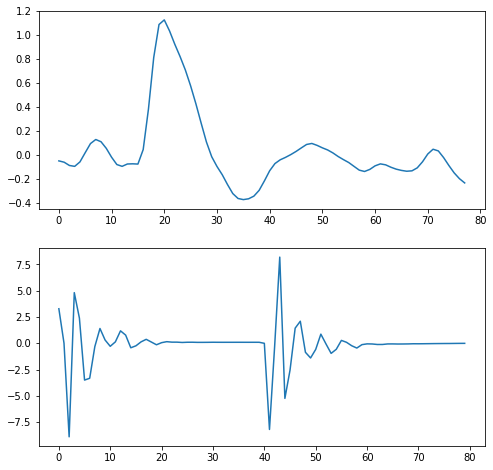

In [22]:
trs, vs,ts, trb, vb, tb, trd, vd, td = preprocessing.splitSim(1, 1, 0, 0.5)

plt.rcParams['figure.figsize'] = [8, 8]     
fig, axs = plt.subplots(2,1)
print(len(torch.fft.irfft(torch.from_numpy(trs[0])[0:40] + 1j * torch.from_numpy(trs[0])[40:]).cpu().detach().numpy()))
axs[0].plot(torch.fft.irfft(torch.from_numpy(trs[0])[0:40] + 1j * torch.from_numpy(trs[0])[40:]).cpu().detach().numpy())
axs[1].plot(trs[0])

plt.savefig('4.2 Dataset.png', facecolor='w')
plt.show()
plt.rcParams['figure.figsize'] = [16, 8]     

In [33]:
# calculate avg confusion matrixes
def defaultSep():
    return {}

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

sepRes = pickle.load(open(f"{resultsPath}/separationRes.pickle", "rb"))
thRes = pickle.load(open(f"{resultsPath}/thresholdingRes.pickle", "rb"))
sepRes2 = pickle.load(open(f"{resultsPath}/separationRes2.pickle", "rb"))
thRes2 = pickle.load(open(f"{resultsPath}/thresholdingRes2.pickle", "rb"))

avgs = defaultdict(lambda: defaultdict(lambda: np.empty((2,2))))

thIt = 0

our = defaultdict(lambda: 0)

sepIt = 0
snr = 1

for it in thRes:
    thIt += 1
    for sd in thRes[it]:
        avgs[sd][snr] += thRes[it][sd][snr][0]

for it in thRes2:
    thIt += 1
    for sd in thRes2[it]:
        avgs[sd][snr] += thRes2[it][sd][snr][0]

for sd in avgs:
    for snr in avgs[sd]:
        avgs[sd][snr] /= thIt

pprint(avgs)

for it in sepRes:
    sepIt += 1
    for snr in sepRes[it]:
        our[snr] += sepRes[it][snr][0]

for it in sepRes2:
    sepIt += 1
    for snr in sepRes2[it]:
        our[snr] += sepRes2[it][snr][0]

pprint(our)
for snr in our:
    our[snr] = our[snr] / sepIt

pprint(our)


defaultdict(<function <lambda> at 0x7f00c81ea040>,
            {1: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c839bc10>,
                            {1: array([[ 4414.80568182, 16297.12      ],
       [ 1147.86818182, 19589.12      ]])}),
             2: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c839bb80>,
                            {1: array([[16939.01534091,  3799.43727273],
       [10282.87784091, 10480.63727273]])}),
             3: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c839baf0>,
                            {1: array([[20226.21534091,   512.23727273],
       [17024.47784091,  3739.03727273]])}),
             4: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c839ba60>,
                            {1: array([[20596.9   ,    57.1   ],
       [19448.8625,  1230.2   ]])}),
             5: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c9036ee0>,
                            {1: array([[2.06476000e+04, 6.40000000e+

In [32]:
# Interpret thresholding results
#avgs -> metric -> sd -> values for specific snr
avgs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

thIt = 0

for it in thresholdingRes:
    thIt += 1
    for sd in thresholdingRes[it]:
        for snr in thresholdingRes[it][sd]:
            avgs["accuracy"][sd][snr] += thresholdingRes[it][sd][snr][1]
            avgs["sensitivity"][sd][snr] += thresholdingRes[it][sd][snr][2]
            avgs["specificity"][sd][snr] += thresholdingRes[it][sd][snr][3]
            avgs["f1"][sd][snr] += thresholdingRes[it][sd][snr][4]
for metric in avgs:
    for sd in avgs[metric]:
        for snr in avgs[metric][sd]:
            avgs[metric][sd][snr] /= thIt
print(json.dumps(avgs["specificity"], indent=4))

{
    "1": {
        "1": 0.21282076111164905,
        "2": 0.21758497143410477,
        "3": 0.22203931441851457,
        "4": 0.22656144088312194,
        "5": 0.23119976759949648,
        "6": 0.2354991769148833
    },
    "2": {
        "1": 0.8173913043478261,
        "2": 0.8218843807494917,
        "3": 0.8264355572770408,
        "4": 0.8307252832381137,
        "5": 0.8351989929311514,
        "6": 0.8396920693328169
    },
    "3": {
        "1": 0.9770214002130337,
        "2": 0.9779800522901134,
        "3": 0.9788128207611116,
        "4": 0.9797521061295633,
        "5": 0.9806623414350731,
        "6": 0.9812820761111649
    },
    "4": {
        "1": 0.9971434104773893,
        "2": 0.9972789774377844,
        "3": 0.9974048610438656,
        "4": 0.9976372615474001,
        "5": 0.9977534617991672,
        "6": 0.9978696620509344
    },
    "5": {
        "1": 0.9997482327878376,
        "2": 0.9997869662050934,
        "3": 0.9998256996223491,
        "4": 0.99983538

defaultdict(<function <lambda> at 0x7f00c90f3430>,
            {'accuracy': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c839ba60>,
                                     {1: 0.8026677641134891,
                                      2: 0.902854168684032,
                                      3: 0.9456957490074561,
                                      4: 0.9668466156676674,
                                      5: 0.9781374067977147,
                                      6: 0.9844533746489785}),
             'f1': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f00c839bc10>,
                               {1: 0.8097937666353768,
                                2: 0.9033597440667496,
                                3: 0.945463374781314,
                                4: 0.9666574391436027,
                                5: 0.9780270335221889,
                                6: 0.9843832221303345}),
             'sensitivity': defaultdict(<function <lambda>.<locals>.<

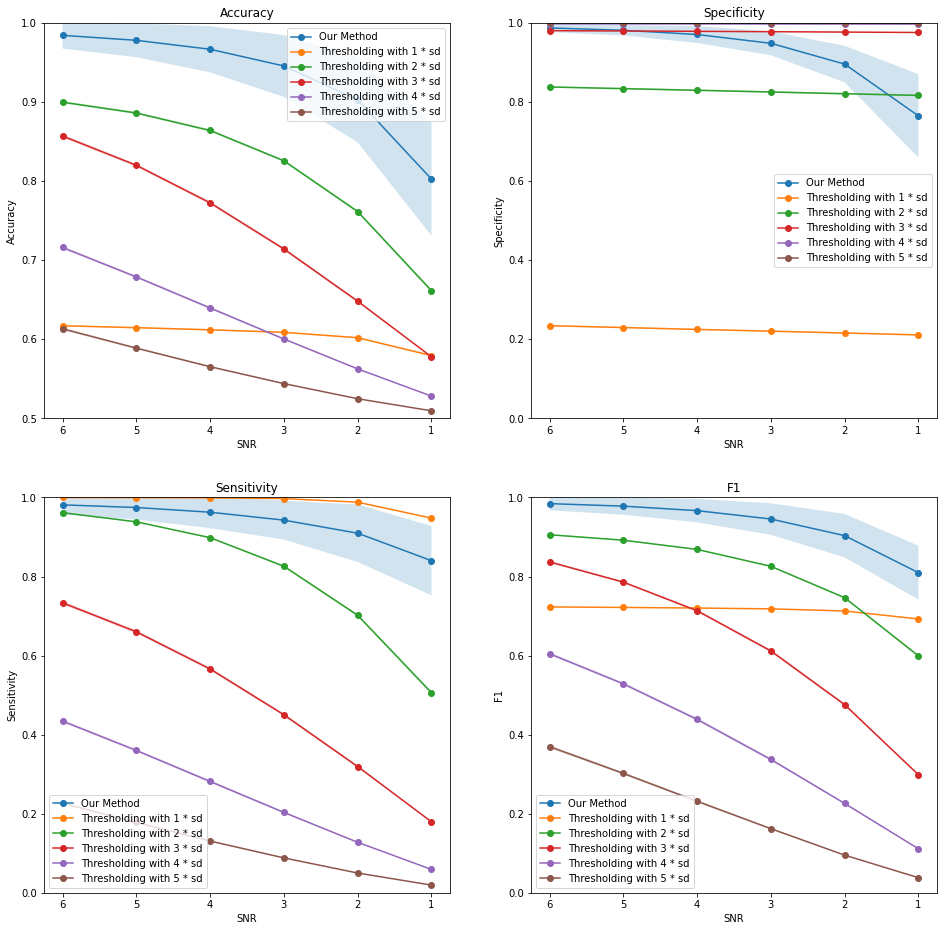

In [32]:
#compute the mean and sds of the metrics
def defaultSep():
    return {}

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

sepRes = pickle.load(open(f"{resultsPath}/separationRes.pickle", "rb"))
thRes = pickle.load(open(f"{resultsPath}/thresholdingRes.pickle", "rb"))
sepRes2 = pickle.load(open(f"{resultsPath}/separationRes2.pickle", "rb"))
thRes2 = pickle.load(open(f"{resultsPath}/thresholdingRes2.pickle", "rb"))

avgs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
sds = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

thIt = 0

our = defaultdict(lambda: defaultdict(lambda: 0))
ourSds = defaultdict(lambda: defaultdict(lambda: 0))

sepIt = 0

for it in thRes:
    thIt += 1
    for sd in thRes[it]:
        for snr in thRes[it][sd]:
            avgs["accuracy"][sd][snr] += thRes[it][sd][snr][1]
            avgs["sensitivity"][sd][snr] += thRes[it][sd][snr][2]
            avgs["specificity"][sd][snr] += thRes[it][sd][snr][3]
            avgs["f1"][sd][snr] += thRes[it][sd][snr][4]

for it in thRes2:
    thIt += 1
    for sd in thRes2[it]:
        for snr in thRes2[it][sd]:
            avgs["accuracy"][sd][snr] += thRes2[it][sd][snr][1]
            avgs["sensitivity"][sd][snr] += thRes2[it][sd][snr][2]
            avgs["specificity"][sd][snr] += thRes2[it][sd][snr][3]
            avgs["f1"][sd][snr] += thRes2[it][sd][snr][4]

for metric in avgs:
    for sd in avgs[metric]:
        for snr in avgs[metric][sd]:
            avgs[metric][sd][snr] /= thIt


for it in thRes:
    for sd in thRes[it]:
        for snr in thRes[it][sd]:
            sds["accuracy"][sd][snr] += np.square(thRes[it][sd][snr][1] - avgs["accuracy"][sd][snr])
            sds["sensitivity"][sd][snr] += np.square(thRes[it][sd][snr][2] - avgs["sensitivity"][sd][snr])
            sds["specificity"][sd][snr] += np.square(thRes[it][sd][snr][3] - avgs["specificity"][sd][snr])
            sds["f1"][sd][snr] += np.square(thRes[it][sd][snr][4] - avgs["f1"][sd][snr])

for it in thRes2:
    for sd in thRes2[it]:
        for snr in thRes2[it][sd]:
            sds["accuracy"][sd][snr] += np.square(thRes2[it][sd][snr][1] - avgs["accuracy"][sd][snr])
            sds["sensitivity"][sd][snr] += np.square(thRes2[it][sd][snr][2] - avgs["sensitivity"][sd][snr])
            sds["specificity"][sd][snr] += np.square(thRes2[it][sd][snr][3] - avgs["specificity"][sd][snr])
            sds["f1"][sd][snr] += np.square(thRes2[it][sd][snr][4] - avgs["f1"][sd][snr])

for metric in sds:
    for sd in sds[metric]:
        for snr in sds[metric][sd]:
            sds[metric][sd][snr] = math.sqrt(sds[metric][sd][snr] / thIt) 

for it in sepRes:
    sepIt += 1
    for snr in sepRes[it]:
        our["accuracy"][snr] += sepRes[it][snr][1]
        our["sensitivity"][snr] += sepRes[it][snr][2]
        our["specificity"][snr] += sepRes[it][snr][3]
        our["f1"][snr] += sepRes[it][snr][4]

for it in sepRes2:
    sepIt += 1
    for snr in sepRes2[it]:
        our["accuracy"][snr] += sepRes2[it][snr][1]
        our["sensitivity"][snr] += sepRes2[it][snr][2]
        our["specificity"][snr] += sepRes2[it][snr][3]
        our["f1"][snr] += sepRes2[it][snr][4]

for metric in our:
    for snr in our[metric]:
        our[metric][snr] /= sepIt


for it in sepRes:
    for sd in sepRes[it]:
        for snr in sepRes[it]:
            ourSds["accuracy"][snr] += np.square(sepRes[it][snr][1] - our["accuracy"][snr])
            ourSds["sensitivity"][snr] += np.square(sepRes[it][snr][2] - our["sensitivity"][snr])
            ourSds["specificity"][snr] += np.square(sepRes[it][snr][3] - our["specificity"][snr])
            ourSds["f1"][snr] += np.square(sepRes[it][snr][4] - our["f1"][snr])

for it in sepRes2:
    for sd in sepRes2[it]:
        for snr in sepRes2[it]:
            ourSds["accuracy"][snr] += np.square(sepRes2[it][snr][1] - our["accuracy"][snr])
            ourSds["sensitivity"][snr] += np.square(sepRes2[it][snr][2] - our["sensitivity"][snr])
            ourSds["specificity"][snr] += np.square(sepRes2[it][snr][3] - our["specificity"][snr])
            ourSds["f1"][snr] += np.square(sepRes2[it][snr][4] - our["f1"][snr])

for metric in ourSds:
    for snr in ourSds[metric]:
        ourSds[metric][snr] = math.sqrt(ourSds[metric][snr] / sepIt) 

plt.rcParams['figure.figsize'] = [16, 16]     
fig, axs = plt.subplots(2,2)

axs[0][0].title.set_text("Accuracy")
axs[0][1].title.set_text("Specificity")
axs[1][0].title.set_text("Sensitivity")
axs[1][1].title.set_text("F1")
axs[0][0].set_xlabel("SNR")
axs[0][1].set_xlabel("SNR")
axs[1][0].set_xlabel("SNR")
axs[1][1].set_xlabel("SNR")
axs[0][0].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Specificity")
axs[1][0].set_ylabel("Sensitivity")
axs[1][1].set_ylabel("F1")


axs[0][0].plot(our["accuracy"].keys(), our["accuracy"].values(), label=f"Our Method", marker='o')
axs[0][0].fill_between(np.array(list(our["accuracy"].keys())), np.array(list(our["accuracy"].values())) - np.array(list(ourSds["accuracy"].values())), np.array(list(our["accuracy"].values())) +  np.array(list(ourSds["accuracy"].values())), alpha=0.2)

axs[0][1].plot(our["specificity"].keys(), our["specificity"].values(), label=f"Our Method", marker='o')
axs[0][1].fill_between(np.array(list(our["specificity"].keys())), np.array(list(our["specificity"].values())) -  np.array(list(ourSds["specificity"].values())), np.array(list(our["specificity"].values())) +  np.array(list(ourSds["specificity"].values())), alpha=0.2)

axs[1][0].plot(our["sensitivity"].keys(), our["sensitivity"].values(), label=f"Our Method", marker='o')
axs[1][0].fill_between(np.array(list(our["sensitivity"].keys())), np.array(list(our["sensitivity"].values())) -  np.array(list(ourSds["sensitivity"].values())), np.array(list(our["sensitivity"].values())) +  np.array(list(ourSds["sensitivity"].values())), alpha=0.2)

axs[1][1].plot(our["f1"].keys(), our["f1"].values(), label=f"Our Method", marker='o')
axs[1][1].fill_between(np.array(list(our["f1"].keys())), np.array(list(our["f1"].values())) -  np.array(list(ourSds["f1"].values())), np.array(list(our["f1"].values())) +  np.array(list(ourSds["f1"].values())), alpha=0.2)

for sd in avgs["accuracy"]:
    axs[0][0].plot(avgs["accuracy"][sd].keys(), avgs["accuracy"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[0][0].fill_between(np.array(list(avgs["accuracy"][sd].keys())), np.array(list(avgs["accuracy"][sd].values())) -  np.array(list(sds["accuracy"][sd].values())), np.array(list(avgs["accuracy"][sd].values())) +  np.array(list(sds["accuracy"][sd].values())), alpha=0.2)
for sd in avgs["specificity"]:
    axs[0][1].plot(avgs["specificity"][sd].keys(), avgs["specificity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[0][1].fill_between(np.array(list(avgs["specificity"][sd].keys())), np.array(list(avgs["specificity"][sd].values())) -  np.array(list(sds["specificity"][sd].values())), np.array(list(avgs["specificity"][sd].values())) +  np.array(list(sds["specificity"][sd].values())), alpha=0.2)
for sd in avgs["sensitivity"]:
    axs[1][0].plot(avgs["sensitivity"][sd].keys(), avgs["sensitivity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[1][0].fill_between(np.array(list(avgs["sensitivity"][sd].keys())), np.array(list(avgs["sensitivity"][sd].values())) -  np.array(list(sds["sensitivity"][sd].values())), np.array(list(avgs["sensitivity"][sd].values())) +  np.array(list(sds["sensitivity"][sd].values())), alpha=0.2)
for sd in avgs["f1"]:
    axs[1][1].plot(avgs["f1"][sd].keys(), avgs["f1"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[1][1].fill_between(np.array(list(avgs["f1"][sd].keys())), np.array(list(avgs["f1"][sd].values())) -  np.array(list(sds["f1"][sd].values())), np.array(list(avgs["f1"][sd].values())) +  np.array(list(sds["f1"][sd].values())), alpha=0.2)

    
pprint(our)
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()

axs[0][0].set_ylim([0.5,1])
axs[0][1].set_ylim([0,1])
axs[1][0].set_ylim([0,1])
axs[1][1].set_ylim([0,1])
axs[0][0].invert_xaxis()
axs[0][1].invert_xaxis()
axs[1][0].invert_xaxis()
axs[1][1].invert_xaxis()

plt.savefig('10-it.png', facecolor='w')
plt.show()
plt.rcParams['figure.figsize'] = [16, 8]     

In [96]:
# generating data for TINS
# thresholding
# setting the it
i = 1
snr = 1
sdMul = 3

trainSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainSpikesLoader.pickle", "rb"))
trainBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainBgLoader.pickle", "rb"))
valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))

mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)

pred = thresholding.thresholdDatasets(mean, sdMul * sd, testSpikesLoader, testBgLoader)

labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

confusionMatrix = testingPipeline.confusionMatrix(labels,pred)

accuracy, sensitivity, specificity, f1 = testingPipeline.metrics(confusionMatrix)

print(f"Results for {sdMul} sd\nConfusion matrix:")
pprint(confusionMatrix)
print(f"\nAccuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

(spikesDataset,) = testSpikesLoader.dataset[:]
(noiseDataset,) = testBgLoader.dataset[:]
dataset = np.concatenate((spikesDataset.numpy(), noiseDataset.numpy()))

thresholdedDataset = dataset[pred == 1]
thresholdedDataset = torch.from_numpy(thresholdedDataset)
thresholdedDataset = np.array([torch.fft.irfft(window[:40] + 1j * window[40:]).numpy() for window in thresholdedDataset])

Results for 3 sd
Confusion matrix:
array([[20152,   502],
       [16983,  3671]])

Accuracy: 0.5767163745521449
Sensitivity: 0.17773796843226494
Specificity: 0.9756947806720248


In [97]:
thresholdedDataset.shape

(4173, 78)

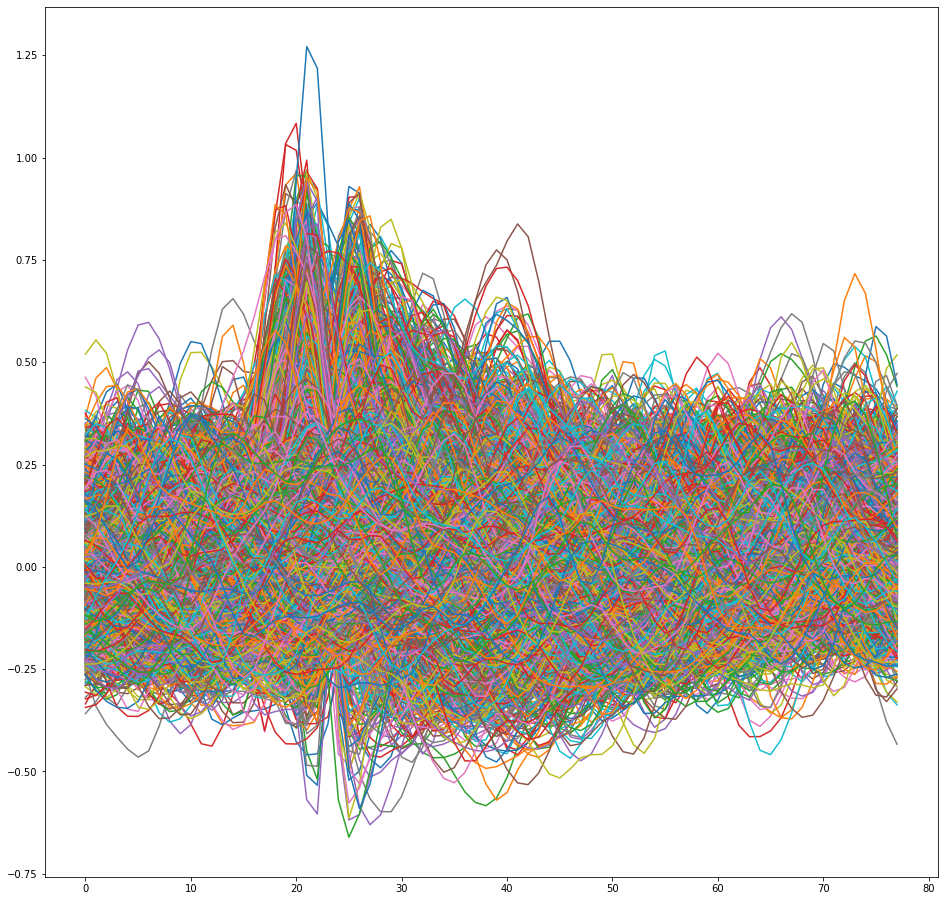

In [18]:
plt.rcParams['figure.figsize'] = [16, 16]
for i, window in enumerate(thresholdedDataset):  
    plt.plot(window)
plt.show()
plt.rcParams['figure.figsize'] = [16, 8]

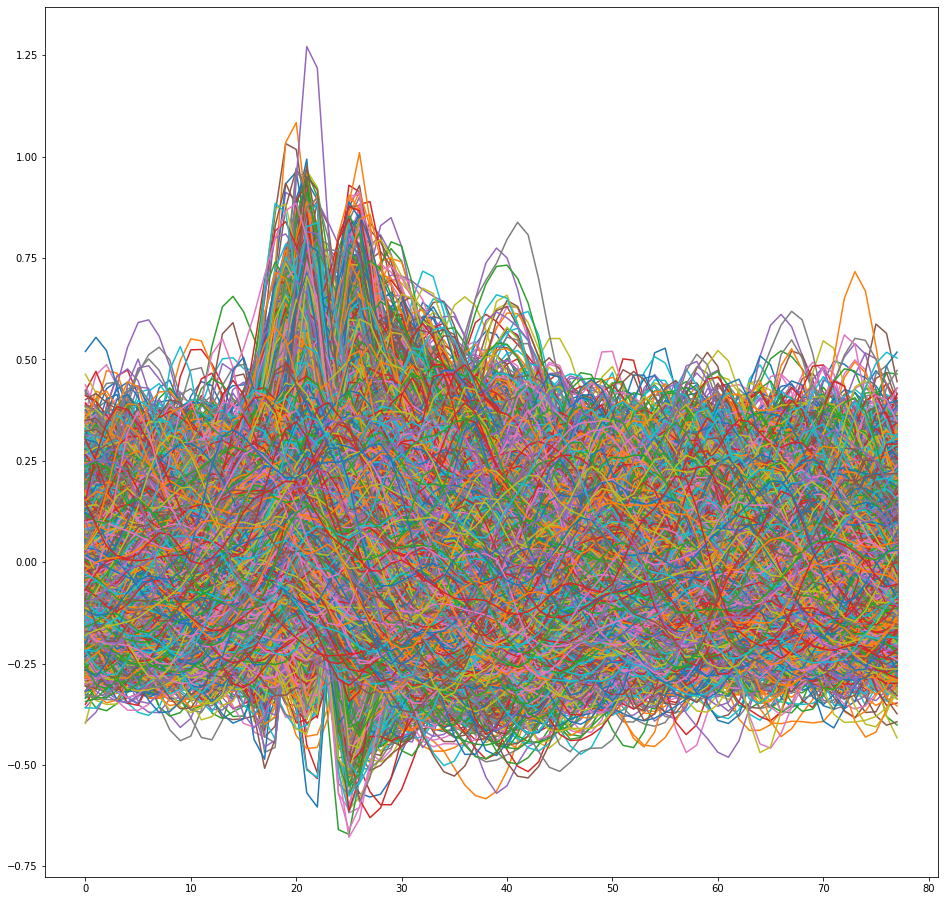

In [22]:
plt.rcParams['figure.figsize'] = [16, 16]
for i, window in enumerate(separatedDataset):  
    plt.plot(window)
plt.show()
plt.rcParams['figure.figsize'] = [16, 8]

In [99]:

setName = "gan"
testingPipeline.epdFormat(separatedDataset, f"../data/epd/{setName}/{setName}_float32.bin", f"../data/epd/{setName}/{setName}_events.bin", f"../data/epd/{setName}/{setName}_labels.bin")

Number of windows: 22535
Number of windows times 78: 1757730
Number of samples: 1757730
First 10 python samples:
[ 0.06162957  0.09124355  0.10761192  0.11103833  0.09829076  0.05995359
  0.00023729 -0.05069136 -0.05198852  0.00730195]
First 10 32 bit samples:
array('f', [0.06162957102060318, 0.09124355018138885, 0.10761191695928574, 0.11103833466768265, 0.09829076379537582, 0.05995359271764755, 0.00023729373060632497, -0.05069136247038841, -0.05198851600289345, 0.00730194803327322])
Number of timestamps: 22535
[1 1 1 ... 1 1 1]
Number of labels: 22535


In [101]:
#sanity
input_file = open(f"../data/epd/{setName}/{setName}_float32.bin", 'rb')
float_array = array('f')
float_array.fromfile(input_file,10)
print(len(float_array))
print(float_array[:10])

10
array('f', [0.06162957102060318, 0.09124355018138885, 0.10761191695928574, 0.11103833466768265, 0.09829076379537582, 0.05995359271764755, 0.00023729373060632497, -0.05069136247038841, -0.05198851600289345, 0.00730194803327322])
